# High PM2.5, Who are the culprits ?

There are three major theories regarding the source air pollution: (1) the source is local: at beginning of winter 2019 the government thought that winter air pollution is naturally occur [temperature inversion effect](https://sciencing.com/effects-temperature-inversion-8447465.html), i.e. when the cold air along with the pollution is trapped closed to the earth surface. At point point the government blamed emission from old diesel engines are to blame. (2) Some people blame the agricultural burning, which maybe from local area and surrounded provinces. Winter is the time with a lot of open agricultural burning activities though out the country. Some officials actually try to tackle the air pollution by reducing open burning activities. (3) the source is not local: there are air pollution from other provinces or countries. Some NGOs blame the pollution of near by power plants. 

My analysis procedure is the following. Build a machine learning model(ML) to predict the air pollution level in Bangkok using environmental factor such as weathers, fire maps, and traffic index. Date-time feature such as local hour, and week of year are included in the model to capture other effects from human activities. Interpret contribution to the pollution using the feature of importance provided by the ML model.


If the pollution is from local pollution then the high AQI should depend on weather pattern such as wind speed, humidity, average temperature, local traffic, and hour of the day. But if the pollution is from agricultural burning the amount of pollution will depends on existence of the active fires with some time lag. The fire activities are included based on the distance from Bangkok. However, if the sources of the pollution is not from the fire map, then the model should consider that weather pattern, such as wind direction and wind speed more importance factors.  

Here are a list of features to consider and their sources: 
- Weather pattern: temperature, wind speed, humidity, and rain, which scrape from [Weather Underground website](thtps://www.wunderground.com/history/daily/th).
- Traffic index from [Longdo Traffic](http://traffic.longdo.com/trafficindex), hour of day, and holiday pattern 
- Active fire information from NASA's [FIRMS](https://firms.modaps.eosdis.nasa.gov) project.


There are some technical aspects to considers. First, what models should I use? Many time series predictions, such as stock markets, employ ARIMA and LSTM models. Many of the example rely on the past value. Here, I aim to includes all the contribution factors in the model; therefore, I will use a simple random forest regression. I also tried using auto ML to hunt for the best model. The output from TPOT although give better R-squared, it put lots of weight on the previous pollution level, which defeat the purpose of this study. I also tried using a shallow network because of the complicate interaction of the feature. The model did not perform well likely because of difficult to hyper parameter tuning process and not enough data. 

Still, care much be taken during the train/test split to prevent spilling over. Second, I can model the pollution change instead of the absolute number. I have tried this approach, but the model has low accuracy. Alternatively, I can turn this problem into a classification problem, which I have tried, but again I didn't get a very good result. Third, I can try to model the daily average PM 2.5 level instead of an hourly average. If I use the daily average, then information about local traffic would be average out, thus not a good method.



In [769]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from IPython.display import display
import matplotlib.dates as mdates
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data, Visualization and Feature Engineer 


1. PM2.5 data, and BKK neighbor provinces
2. Weather data: temperature, wind speed, humidity, and rain, which scrape from [Weather Underground website](thtps://www.wunderground.com/history/daily/th)
3. Active fire map from NASA's [FIRMS](https://firms.modaps.eosdis.nasa.gov) project.
4. Traffic index from [Longdo Traffic](http://traffic.longdo.com/trafficindex) measured hourly


## 1. PM2.5 data, and BKK neighbor provinces

Load PM2.5 data for all regions, combine with regional information, keep only Bangkok and the neighbor provinces with < 200 km away.

In [304]:
# load the regional information with latitude and longitude information in 
# mercadian coordinate
region_df = pd.read_csv('data/model/region_info.csv',sep=';')
#convert the unit to km
region_df['x_mer'] = region_df['x_mer']/1000
region_df['y_mer'] = region_df['y_mer']/1000
region_df['dis2BKK'] = region_df['dis2BKK']/1000

In [305]:
region_df.sort_values('dis2BKK').head()

City        Region  Population  Latitude  Longitude  \
0             Bangkok       Bangkok     5104476   13.7540   100.5014   
1          Bang Kruai    Nonthaburi       78305   13.8050   100.4728   
37      Phra Pradaeng  Samut Prakan      171333   13.6585   100.5336   
25  Mueang Nonthaburi    Nonthaburi      291555   13.8607   100.5148   
31           Pak Kret    Nonthaburi      182926   13.9130   100.4988   

           x_mer        y_mer    dis2BKK  
0   11187.764672  1544.967921   0.000000  
1   11184.580935  1550.778546   6.625674  
37  11191.349160  1534.090704  11.452615  
25  11189.256353  1557.126140  12.249384  
31  11187.475241  1563.087681  18.122072

There is a little confusion in the city and region columns. City in fact refer to a subprovince and region actually refer to the province. In this record, most regions have one city in it, but a few regions have 2 - 3 cities.  

In [306]:
# select provinces, which is less than 200 km away 
region_df = region_df.query('dis2BKK < 200')

In [307]:
# read the air pollution data for all province
pm25_all = pd.read_csv('data/model/pm25_all.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
# merge with the region
pm25_all = pm25_all.merge(region_df, left_on=['city'], right_on='City')
pm25_all.set_index('Time',inplace=True)

In [308]:
# select pm2.5 data in provinces, which is less than 200 km away
# generate the province list
provinceslist = region_df['Region'].values
# keep BKK neighbor
pm25_all = pm25_all[pm25_all['Region'].isin(provinceslist)]
# drop the city, City columns
pm25_all = pm25_all.drop(['city','City'],axis=1)

In [309]:
# put the pm2.5 into category and color for visualizing purpose
pm25_all['level'] = pd.cut(pm25_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
pm25_all['color'] = pd.cut(pm25_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])

# create time features 
pm25_all['day'] = pm25_all.index.day 
pm25_all['date'] = pm25_all.index.date
pm25_all['quarter'] = pm25_all.index.quarter
pm25_all['month'] = pm25_all.index.month
pm25_all['DayofYear'] = pm25_all.index.dayofyear
pm25_all['DayofWeek'] = pm25_all.index.dayofweek
pm25_all['weekofyear'] = pm25_all.index.weekofyear
pm25_all['TimeofDay'] = pm25_all.index.time

pm25_all['is_weekend'] = pm25_all.index.dayofweek.isin([5,6])*1

pm25_all['month-year'] = pm25_all.index.strftime('%b-%Y')
pm25_all['season'] = 'other'
pm25_all.loc[pm25_all['month'].isin([12,1,2]),'season'] ='winter'

In [310]:
pm25_all.describe()

PM2.5    Population       Latitude      Longitude  \
count  641359.000000  6.413590e+05  641359.000000  641359.000000   
mean       25.437474  3.009747e+05      13.721813     100.506176   
std        15.546214  9.596860e+05       0.594225       0.473714   
min         1.000000  5.045600e+04      12.570700      99.548300   
25%        14.500000  5.776100e+04      13.536700     100.122200   
50%        21.300000  7.830500e+04      13.805000     100.533600   
75%        32.200000  1.185510e+05      14.004100     100.795400   
max       714.900000  5.104476e+06      14.798100     101.648300   

               x_mer          y_mer        dis2BKK            day  \
count  641359.000000  641359.000000  641359.000000  641359.000000   
mean    11188.296310    1541.388345      71.552658      15.719043   
std        52.733619      67.667218      47.465694       8.776074   
min     11081.666065    1410.501300       0.000000       1.000000   
25%     11145.552321    1520.224488      29.248499       8.000000   
50%     11191.349160    1550.778546      69.825095      16.000000   
75%     11220.492602    1573.475216     109.861641      23.000000   
max     11315.436996    1664.190781     169.023405      31.000000   

             quarter          month      DayofYear      DayofWeek  \
count  641359.000000  641359.000000  641359.000000  641359.000000   
mean        2.504264       6.532424     183.427101       2.965754   
std         1.119287       3.432222     104.972110       1.984841   
min         1.000000       1.000000       1.000000       0.000000   
25%         1.000000       3.000000      91.000000       1.000000   
50%         3.000000       7.000000     183.000000       3.000000   
75%         4.000000      10.000000     274.000000       5.000000   
max         4.000000      12.000000     366.000000       6.000000   

          weekofyear     is_weekend  
count  641359.000000  641359.000000  
mean       26.520161       0.275842  
std        14.950607       0.446938  
min         1.000000       0.000000  
25%        13.000000       0.000000  
50%        26.000000       0.000000  
75%        39.000000       1.000000  
max        52.000000       1.000000

Obtain Thailand holiday information from https://www.timeanddate.com/holidays/thailand/

In [469]:
years = ['2016','2017','2018','2019']
holiday = pd.DataFrame()
for year in years:
    url = 'https://www.timeanddate.com/holidays/thailand/' + year
    df = pd.read_html(url)[0]
    df['Date'] = year + ' ' +df['Date']
    holiday = pd.concat([holiday,df])
    

In [470]:
holiday.columns = [name1 for name1,name2 in holiday.columns]

In [471]:
holiday['Date'] = pd.to_datetime(holiday['Date'], format='%Y %b %d')
holiday = holiday[holiday['Holiday Type'] == 'National holiday']
holiday.head()

Date    Weekday    Holiday Name      Holiday Type
0  2016-01-01     Friday  New Year's Day  National holiday
7  2016-02-22     Monday     Makha Bucha  National holiday
9  2016-04-06  Wednesday      Chakri Day  National holiday
10 2016-04-13  Wednesday        Songkran  National holiday
11 2016-04-14   Thursday        Songkran  National holiday

In [213]:
holiday.to_csv('holiday.csv',index=False)

In [311]:
holiday = pd.read_csv('holiday.csv')
# add holiday columns into the pm25 table 
pm25_all['is_holiday'] = pm25_all.index.isin(holiday['Date'])*1

In [312]:
pm25_all.head()

PM2.5   Region  Population  Latitude  Longitude  \
Time                                                                   
2016-03-03 15:00:00   62.9  Bangkok     5104476    13.754   100.5014   
2016-03-03 16:00:00   62.9  Bangkok     5104476    13.754   100.5014   
2016-03-03 17:00:00   55.5  Bangkok     5104476    13.754   100.5014   
2016-03-03 18:00:00   55.5  Bangkok     5104476    13.754   100.5014   
2016-03-03 19:00:00   47.9  Bangkok     5104476    13.754   100.5014   

                            x_mer        y_mer  dis2BKK      level   color  \
Time                                                                         
2016-03-03 15:00:00  11187.764672  1544.967921      0.0  unhealthy     red   
2016-03-03 16:00:00  11187.764672  1544.967921      0.0  unhealthy     red   
2016-03-03 17:00:00  11187.764672  1544.967921      0.0  unhealthy  orange   
2016-03-03 18:00:00  11187.764672  1544.967921      0.0  unhealthy  orange   
2016-03-03 19:00:00  11187.764672  1544.967921      0.0   moderate  orange   

                     ...  quarter month  DayofYear  DayofWeek  weekofyear  \
Time                 ...                                                    
2016-03-03 15:00:00  ...        1     3         63          3           9   
2016-03-03 16:00:00  ...        1     3         63          3           9   
2016-03-03 17:00:00  ...        1     3         63          3           9   
2016-03-03 18:00:00  ...        1     3         63          3           9   
2016-03-03 19:00:00  ...        1     3         63          3           9   

                     TimeofDay  is_weekend month-year  season is_holiday  
Time                                                                      
2016-03-03 15:00:00   15:00:00           0   Mar-2016   other          0  
2016-03-03 16:00:00   16:00:00           0   Mar-2016   other          0  
2016-03-03 17:00:00   17:00:00           0   Mar-2016   other          0  
2016-03-03 18:00:00   18:00:00           0   Mar-2016   other          0  
2016-03-03 19:00:00   19:00:00           0   Mar-2016   other          0  

[5 rows x 22 columns]

In [313]:
# save the data 
pm25_all.to_csv('data/model/pm25bkknear_proc.csv')

In [499]:
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.set_index('Time')
bkkpm = pm25_all[pm25_all['Region'] == 'Bangkok']
nearbkkpm = pm25_all[pm25_all['Region'] != 'Bangkok']

The amount of air pollution in the next hour will depends on the amount of pollution in the previous time because the pollution will remain in the air for a while. This is captured in author correlation function and partial auto-correlation function. 

The partial auto-correlation function is the correlation with the previous time steps with the earlier effect accounted for. The partial autocorrelation plot below shows a strong correlation at 1 hr time lag, which means the PM 2.5 level is an autoregression process



In [501]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot

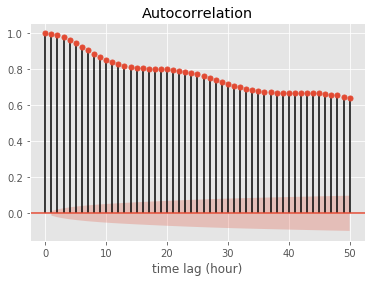

In [315]:
plot_acf(pmnear['Bangkok'], lags=50)
plt.xlabel('time lag (hour)')
pyplot.show()

Text(5, 0.8, '1 hour lag')

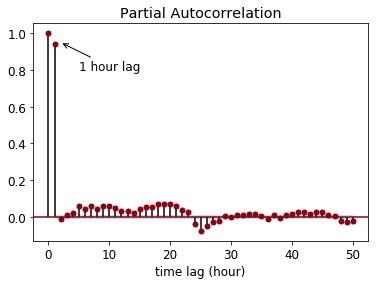

In [625]:
plot_pacf(bkkpm['PM2.5'], lags=50,color='xkcd:crimson')
plt.xlabel('time lag (hour)')
plt.annotate('1 hour lag',xy=(2,0.95),xytext=(5,0.8), arrowprops=dict(arrowstyle="->"))

## 2. Weather data

I wrote a program to scrape weather data from Weather Underground. It is stored in the data/weather folder. After putting all the files into a DataFrame, I convert the unit to SI unit, and explore different between the weather pattern in winter (with high pollution) and in other season. I put all features into the model, and drop the features. At the end, I use Humidity, and Wind speed. 


In [443]:
# load the data from all files
weather_f = glob('data/weather/weather_*.csv')
weather = pd.DataFrame()
for file in weather_f:
    weather = pd.concat([weather,pd.read_csv(file)])
weather = weather.drop('Unnamed: 0',axis=1)
weather=weather.sort_values('date')

In [444]:
# convert F to C,  mph to kmh and in to mm 
weather['Temperature(C)'] = (weather['Temperature(F)'] - 32)*5/9
weather['Dew Point(C)'] = (weather['Dew Point(F)'] - 32)*5/9
weather['Wind Speed(kmh)'] = weather['Wind Speed(mph)'] * 1.609344 

In [445]:
weather['Condition'].unique()

array(['Fair', 'Partly Cloudy', 'Fog', 'Mostly Cloudy', 'Light Rain', 'Showers in the Vicinity',
       'Heavy Rain Shower', 'Heavy T-Storm', 'Light Rain with Thunder', 'Light Rain Shower', 'Haze',
       'T-Storm', 'Rain', 'Smoke', 'Light Rain / Windy', 'Thunder in the Vicinity', 'Fair / Windy',
       'Heavy Rain', 'Partly Cloudy / Windy', 'T-Storm / Windy', 'Heavy T-Storm / Windy', 'Rain / Windy',
       'Thunder', 'Rain Shower', 'Light Drizzle', 'Heavy Rain Shower / Windy', 'Mist',
       'Mostly Cloudy / Windy', 'Rain Shower / Windy', 'Cloudy', 'Light Rain Shower / Windy',
       'Heavy Rain / Windy'], dtype=object)

In [446]:
weather['Wind'].unique()

array(['NE', 'NNE', 'E', 'ENE', 'N', 'NNW', 'CALM', 'SSE', 'VAR', 'ESE', 'NW', 'SE', 'WNW', 'S', 'SW', 'WSW',
       'W', 'SSW', nan], dtype=object)

Condition and Wind columns are description of the weather. I extract the key words such as if it rain (humidity and water help reduce the pollution). Calm wind is going to make the pollution worse because the existing pollution would add to the newly generated pollution.  

In [447]:
# extract key words and turn it into new columns
weather['is_rain'] = weather['Condition'].str.contains('Rain|Drizzle|Thunder|Storm|Shower')*1
weather['is_fair'] = weather['Condition'].str.contains('Fair')*1
weather['is_cloudy'] = weather['Condition'].str.contains('Cloudy')*1
weather['is_fog'] = weather['Condition'].str.contains('Fog|Mist')*1
weather['is_windy'] = weather['Condition'].str.contains('Windy')*1

# drop emperial unit columns 
weather = weather.drop(['Temperature(F)', 'Dew Point(F)',
       'Wind Speed(mph)', 'Wind Gust(mph)', 'Pressure(in)', 'Precip.(in)',
       'Precip Accum(in)','Time'],axis=1)

In [186]:
weather.columns

Index(['Humidity(%)', 'Wind', 'Condition', 'date', 'Temperature(C)',
       'Dew Point(C)', 'Wind Speed(kmh)', 'is_rain', 'is_fair', 'is_cloudy',
       'is_fog', 'is_windy', 'is_calm'],
      dtype='object')

In [187]:
# save for later use 
weather.to_csv('data//model/weatherall.csv',index=False)

### Explore Weather Data

In [870]:
# Load the data
weather = pd.read_csv('data/model/weatherall.csv').dropna()
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.set_index('date').sort_index()
# look at difference between winter and not winter
weather['season'] = 'other'
weather.loc[np.isin(weather.index.month, [12, 1, 2]), 'season'] = 'winter'
weather[['Wind', 'Condition', 'season', 'is_rain', 'is_fair',
         'is_cloudy', 'is_fog', 'is_windy', 'is_calm']] = weather[['Wind', 'Condition', 'season', 'is_rain', 'is_fair', 'is_cloudy', 'is_fog', 'is_windy', 'is_calm']].astype('category')

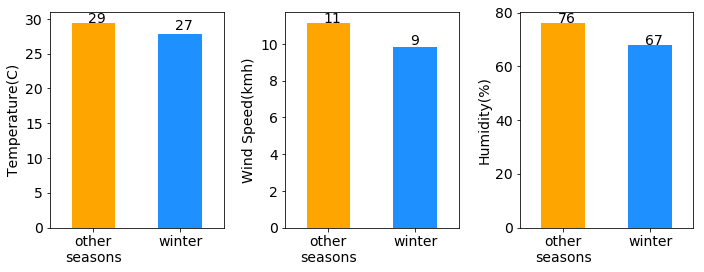

In [68]:
#set plt font size
plt.rcParams.update({'font.size': 14})

# explore difference between winter and other season
season = weather[['Temperature(C)','Wind Speed(kmh)','Humidity(%)',
         'season']].groupby('season',as_index=False).mean()

season = pd.melt(season,id_vars='season')

# set plot parameter
barwidth = 0.9
colors = ['orange','dodgerblue']

#plot temperature
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
data= season[season['variable']=='Temperature(C)']
data.plot(x='variable',y='value', kind='bar',ax=ax1, color=colors, legend=None)
ax1.set_xticklabels(['other\nseasons','winter'],rotation=0)
plt.xlabel('')
plt.ylabel('Temperature(C)')

# create bar addnotation
barlabels = data.value.values.astype(int).astype(str)
xys = [(0.22,0.95), (0.72,0.92)]
# Text on the top of each barplot
plt.annotate(barlabels[0],xycoords='axes fraction',xy = xys[0],
            textcoords='axes fraction', xytext= xys[0])
plt.annotate(barlabels[1],xycoords='axes fraction',xy = xys[1],
            textcoords='axes fraction', xytext= xys[1])

# plot wind speed 
ax2 = fig.add_subplot(132)
data= season[season['variable']=='Wind Speed(kmh)']
data.plot(x='variable',y='value', kind='bar',ax=ax2, color=colors, legend=None)
ax2.set_xticklabels(['other\nseasons','winter'],rotation=0)
plt.xlabel('')
plt.ylabel('Wind Speed(kmh)')

# create bar addnotation
barlabels = data.value.values.astype(int).astype(str)
xys = [(0.22,0.95), (0.72,0.85)]
# Text on the top of each barplot
plt.annotate(barlabels[0],xycoords='axes fraction',xy = xys[0],
            textcoords='axes fraction', xytext= xys[0])
plt.annotate(barlabels[1],xycoords='axes fraction',xy = xys[1],
            textcoords='axes fraction', xytext= xys[1])

# plot humidity
ax3 = fig.add_subplot(133)
data= season[season['variable']=='Humidity(%)']
data.plot(x='variable',y='value', kind='bar',ax=ax3, color=colors, legend=None)
ax3.set_xticklabels(['other\nseasons','winter'],rotation=0)
plt.xlabel('')
plt.ylabel('Humidity(%)')

# create bar addnotation
barlabels = data.value.values.astype(int).astype(str)
xys = [(0.22,0.95), (0.72,0.85)]
# Text on the top of each barplot
plt.annotate(barlabels[0],xycoords='axes fraction',xy = xys[0],
            textcoords='axes fraction', xytext= xys[0])
plt.annotate(barlabels[1],xycoords='axes fraction',xy = xys[1],
            textcoords='axes fraction', xytext= xys[1])

plt.tight_layout()

In [96]:
data.value.values.astype(int).astype(str)

array(['76', '67'], dtype='<U11')

In [356]:
season.head()

season         variable      value
0   other   Temperature(C)  29.450150
1  winter   Temperature(C)  27.804020
2   other  Wind Speed(kmh)  11.159669
3  winter  Wind Speed(kmh)   9.829937
4   other      Humidity(%)  76.224405

Temperature, wind speed, and humidity decreases in winter, but how does this change with the PM2.5 particle? 

### Relationship with the PM 2.5 particles

Explore relationship between weather pattern and the level of PM2.5 particles

In [871]:
# load pm2.5 data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',['PM2.5','level','color']]

In [872]:
# merge with weather data by datetime
pm_weather = weather.merge(bkkpm,how='right',left_index=True,right_index=True)
pm_weather = pm_weather.sort_index()
pm_weather.drop('Dew Point(C)',axis=1,inplace=True)

In [113]:
pm_weather.shape, pm_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24454 entries, 2016-03-03 15:00:00 to 2019-03-20 20:00:00
Data columns (total 15 columns):
Humidity(%)        24341 non-null float64
Wind               24341 non-null category
Condition          24341 non-null category
Temperature(C)     24341 non-null float64
Wind Speed(kmh)    24341 non-null float64
is_rain            24341 non-null category
is_fair            24341 non-null category
is_cloudy          24341 non-null category
is_fog             24341 non-null category
is_windy           24341 non-null category
is_calm            24341 non-null category
season             24341 non-null category
PM2.5              24454 non-null float64
level              24454 non-null object
color              24454 non-null object
dtypes: category(9), float64(4), object(2)
memory usage: 1.5+ MB


((24454, 15), None)

I make the data less crowd, I am going to look at the data during January - March 2018. This is the period with both low and high pollution levels, but is stil in winter season.

In [114]:
cols = pm_weather.columns[:11].values
cols

array(['Humidity(%)', 'Wind', 'Condition', 'Temperature(C)', 'Wind Speed(kmh)', 'is_rain', 'is_fair',
       'is_cloudy', 'is_fog', 'is_windy', 'is_calm'], dtype=object)

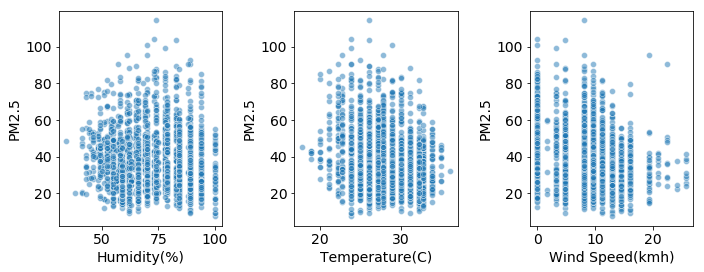

In [154]:
# explore a specific time with low and high PM
data = pm_weather['2018-01-01':'2018-03-31']
fig, ax = plt.subplots(1,3,figsize=(10,4))
ax = ax.flat
idxs = [0,3,4]
for i,idx  in enumerate(idxs):
    sns.scatterplot(data=data, x= cols[idx],y='PM2.5',ax=ax[i],alpha=0.5) 

plt.tight_layout()

In [168]:
# get rid of the outliers in the wind speed column
col = 'Wind Speed(kmh)'
pm_weather[col].quantile(0.999)
pm_weather.loc[pm_weather[col] >q,col] = pm_weather[col].quantile(0.99)

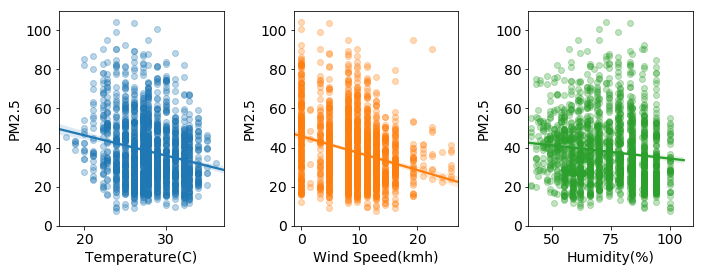

In [176]:
# explore relationship with PM2.5
data = pm_weather['2018-01-01':'2018-03-31']
fig, ax = plt.subplots(1,3,figsize=(10,4))
ax = ax.flat
cols = ['Temperature(C)', 'Wind Speed(kmh)','Humidity(%)']
for i,col  in enumerate(cols):
    sns.regplot(data=data, x= col,y='PM2.5',ax=ax[i],scatter_kws={'alpha':0.3})
    ax[i].axes.set_ylim([0,110]) 

ax[2].axes.set_xlim([40,110])

plt.tight_layout()

There are some relationship between the weather pattern and PM2.5 level, but very noisy ones. The PM 2.5 is low for high humidity, high temperature, and wind speed.

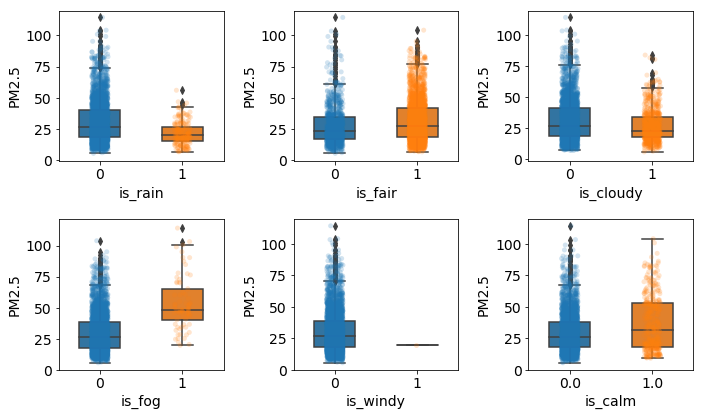

In [255]:
# relationship with pm2.5
data = pm_weather['2018-01-01':'2018-05-31']
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax = ax.flat
conditions = ['is_rain', 'is_fair',
       'is_cloudy', 'is_fog', 'is_windy', 'is_calm']
for i,con  in enumerate(conditions):
    sns.catplot(data=data, x= con, y='PM2.5',alpha=0.2, legend=False,ax=ax[i] ) 
    plt.close(2)
    sns.boxplot(data=data, x= con, y='PM2.5',width=0.5,ax=ax[i])

plt.tight_layout()

Rain seem to be the only condition with less pollution. No different for other conditions. This means we only need the rain column. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 <a list of 18 Text xticklabel objects>)

<Figure size 288x288 with 0 Axes>

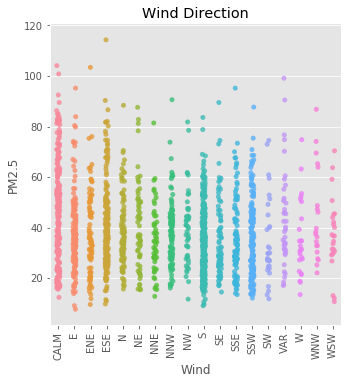

In [480]:
# explore a specific time with low and high PM
fig = plt.figure(figsize=(4,4))
sns.catplot(data=data, x= 'Wind', y='PM2.5',alpha=0.8, legend=False) 
plt.title('Wind Direction')
plt.xticks(rotation = 90)

Want to rank the average PM2.5 by the wind direction, first need to get the sort the index by the average PM2.5 value. 

In [89]:
temp = data[['PM2.5','Wind']].groupby('Wind',as_index=False).agg(['mean','std'])
temp.columns = ['mean','std']
temp = temp.sort_values('mean',ascending=False)
temp.head()

mean        std
Wind                      
W     53.492857  17.453960
CALM  49.657669  18.660723
WNW   46.100000  15.955998
VAR   43.446154  20.445264
NW    41.534722  18.549038

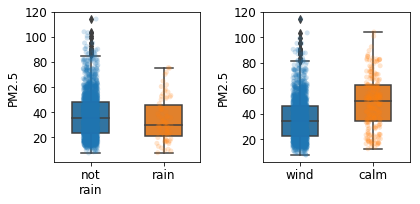

In [308]:
#set plt font size
plt.rcParams.update({'font.size': 12})
#subset the data
data = pm_weather['2017-12-01':'2018-02-28']
fig,ax = plt.subplots(1,2,figsize=(6,3), gridspec_kw = {'width_ratios':[1, 1]})
cons = ['is_rain', 'is_calm']

# plot rain relationship with pm2.5
sns.catplot(data=data, x= cons[0], y='PM2.5',alpha=0.2, legend=False,ax=ax[0]) 
plt.close(2)
sns.boxplot(data=data,x=cons[0], y='PM2.5',ax=ax[0],width=0.5)
#close extra figure generated by sns
ax[0].axes.set_xticklabels(['not\nrain', 'rain'])
ax[0].axes.set_xlabel('')

# plot is_calm 
sns.catplot(data=data, x= cons[1], y='PM2.5',alpha=0.2, legend=False,ax=ax[1]) 
plt.close(2)
sns.boxplot(data=data,x=cons[1], y='PM2.5',ax=ax[1],width=0.5)
#close extra figure generated by sns
ax[1].axes.set_xticklabels(['wind', 'calm'])
ax[1].axes.set_xlabel('')


plt.tight_layout()

The effect of rain is unclear from the above plot because there are many days with is not raining, but still have good weather. One should see that for all rainy day tend to have lower air pollution level. To make thing clearer, I try using histogram instead.

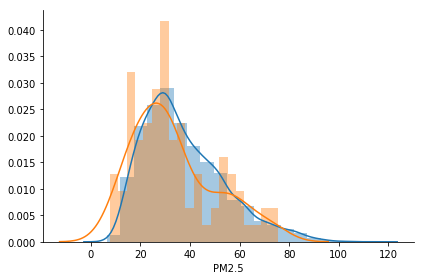

In [886]:
data = pm_weather.query('season== "winter"')
g = sns.FacetGrid(data, hue="is_rain", height=4, aspect=1.5)
g = g.map(sns.distplot, "PM2.5",bins=20,kde=True)

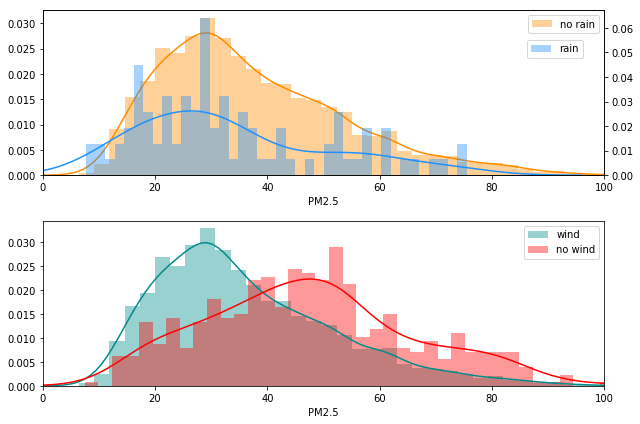

In [928]:
data = pm_weather.query('season== "winter"')

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(9,6))
bins = 40
sns.distplot(data.loc[data['is_rain']==0,'PM2.5'],bins=bins,ax=ax1, color='darkorange')
ax1.set_xlim([0,100])
ax1.legend(labels=['no rain'])
# create a twin axis
ax1t = ax1.twinx() 
sns.distplot(data.loc[data['is_rain']==1,'PM2.5'],bins=bins,ax=ax1t, color='dodgerblue')
ax1t.legend(labels=['rain'],loc='upper right', bbox_to_anchor=(0.97,0.85))


g = sns.FacetGrid(data, hue="is_calm",palette=['darkcyan','red'])
g = g.map(sns.distplot, "PM2.5",bins=bins,kde=True,ax=ax2)
ax2.legend(labels=['wind','no wind'])
ax2.set_xlim([0,100])
plt.close(2)

plt.tight_layout()

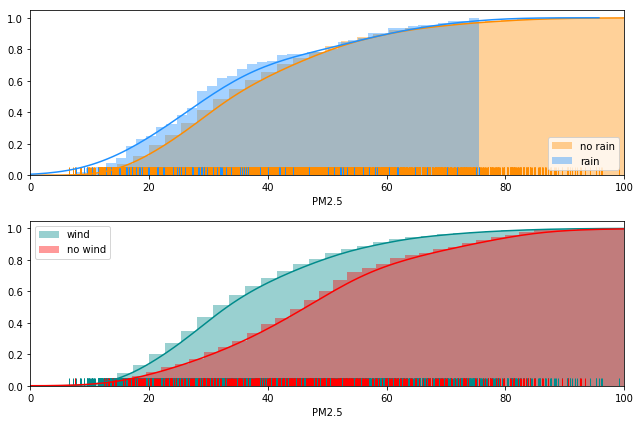

In [943]:
data = pm_weather.query('season== "winter"')

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(9,6))
bins = 40

g = sns.FacetGrid(data, hue="is_rain",palette=['darkorange','dodgerblue'])
g = g.map(sns.distplot, "PM2.5",bins=bins,kde=True,ax=ax1, hist_kws={'cumulative': True}, kde_kws={'cumulative': True},rug=True)
ax1.set_xlim([0,100])
ax1.legend(labels=['no rain','rain'],loc='lower right')
plt.close(2)

g = sns.FacetGrid(data, hue="is_calm",palette=['darkcyan','red'])
g = g.map(sns.distplot, "PM2.5",bins=bins,kde=True,ax=ax2,hist_kws={'cumulative': True}, kde_kws={'cumulative': True},rug=True)
ax2.legend(labels=['wind','no wind'])
ax2.set_xlim([0,100])
plt.close(2)

plt.tight_layout()

In [961]:
med['PM2.5'].values

array([34. , 29.1])

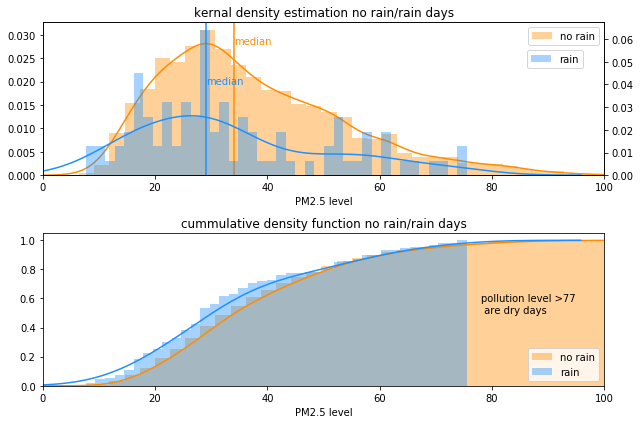

In [988]:
data = pm_weather.query('season== "winter"')
med = data[['PM2.5','is_rain']].groupby('is_rain').median().values

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(9,6))
bins = 40
sns.distplot(data.loc[data['is_rain']==0,'PM2.5'],bins=bins,ax=ax1, color='darkorange')
ax1.set_xlim([0,100])
ax1.legend(labels=['no rain'])
ax1.set_xlabel('PM2.5 level')
#plot the vertical line indicating median
ax1.axvline(x=med[0],color='darkorange')
ax1.text(x=med[0],y=0.028,s='median',color='darkorange')

# create a twin axis for plotting data on a rainy day
ax1t = ax1.twinx() 
sns.distplot(data.loc[data['is_rain']==1,'PM2.5'],bins=bins,ax=ax1t, color='dodgerblue')
ax1t.legend(labels=['rain'],loc='upper right', bbox_to_anchor=(0.97,0.85))
#plot the vertical line indicating median
ax1t.axvline(x=med[1],color='dodgerblue')
ax1t.text(x=med[1],y=0.04,s='median',color='dodgerblue')
#add plot title
ax1.set_title('kernal density estimation no rain/rain days')


g = sns.FacetGrid(data, hue="is_rain",palette=['darkorange','dodgerblue'])
g = g.map(sns.distplot, "PM2.5",bins=bins,kde=True,ax=ax2, hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
ax2.set_xlim([0,100])
ax2.legend(labels=['no rain','rain'],loc='lower right')
ax2.set_xlabel('PM2.5 level')
#add plot title
ax2.set_title('cummulative density function no rain/rain days')
#add text 
ax2.text(x=78,y=0.5,s='pollution level >77\n are dry days')

plt.close(2)
plt.tight_layout()

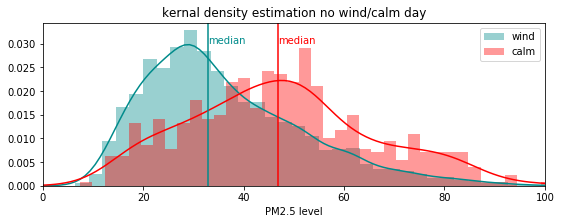

In [993]:
med = data[['PM2.5','is_calm']].groupby('is_calm').median().values

fig,ax2 = plt.subplots(figsize=(9,3))
g = sns.FacetGrid(data, hue="is_calm",palette=['darkcyan','red'])
g = g.map(sns.distplot, "PM2.5",bins=bins,kde=True,ax=ax2)
ax2.legend(labels=['wind','calm'])
ax2.set_xlim([0,100])
ax2.set_xlabel('PM2.5 level')

# add median line
ax2.axvline(x=med[0],color='darkcyan')
ax2.text(x=med[0],y=0.03,s='median',color='darkcyan')
ax2.axvline(x=med[1],color='red')
ax2.text(x=med[1],y=0.03,s='median',color='red')

ax2.set_title('kernal density estimation no wind/calm day')
plt.close(2)

Alternatively, I can look for the immediate effect of the rain by plotting the pollution before and after the rain. There are a lot of complications because of other factor involved. A better approach is to use partial dependence, but that is after I have gotten a model. 

In [150]:
# look for a rainy day 
pm_weather.query('is_rain==True & season == "winter"').tail(20)

Humidity(%)  Wind                Condition  \
2018-02-27 03:00:00        100.0   NNW               Light Rain   
2018-02-27 04:00:00        100.0   ESE               Light Rain   
2018-02-27 17:00:00         66.0    SE               Light Rain   
2018-02-27 18:00:00         94.0   NNW  Light Rain with Thunder   
2018-02-28 17:00:00         74.0     S                  T-Storm   
2018-02-28 18:00:00         84.0    SE               Light Rain   
2018-12-08 04:00:00         89.0   SSE  Light Rain with Thunder   
2018-12-08 05:00:00        100.0   SSW               Light Rain   
2018-12-08 09:00:00        100.0   VAR               Light Rain   
2018-12-08 10:00:00        100.0     N               Light Rain   
2018-12-08 11:00:00        100.0   NNW               Light Rain   
2018-12-08 12:00:00         94.0    NW               Light Rain   
2019-01-06 02:00:00         83.0     W               Light Rain   
2019-01-06 03:00:00         94.0  CALM               Light Rain   
2019-01-06 04:00:00         94.0   WNW               Light Rain   
2019-01-08 13:00:00         74.0     E  Showers in the Vicinity   
2019-01-08 14:00:00         74.0   ESE        Light Rain Shower   
2019-01-08 15:00:00         79.0   ESE               Light Rain   
2019-01-09 15:00:00         70.0    NE  Showers in the Vicinity   
2019-01-09 16:00:00         89.0   WNW               Light Rain   

                     Temperature(C)  Wind Speed(kmh) is_rain is_fair  \
2018-02-27 03:00:00       23.888889         4.828032       1       0   
2018-02-27 04:00:00       23.888889         4.828032       1       0   
2018-02-27 17:00:00       31.111111         9.656064       1       0   
2018-02-27 18:00:00       22.777778        25.749504       1       0   
2018-02-28 17:00:00       27.777778        16.093440       1       0   
2018-02-28 18:00:00       27.222222         8.046720       1       0   
2018-12-08 04:00:00       26.111111        14.484096       1       0   
2018-12-08 05:00:00       25.000000         8.046720       1       0   
2018-12-08 09:00:00       22.777778         3.218688       1       0   
2018-12-08 10:00:00       23.888889         4.828032       1       0   
2018-12-08 11:00:00       23.888889         8.046720       1       0   
2018-12-08 12:00:00       25.000000        14.484096       1       0   
2019-01-06 02:00:00       25.000000         8.046720       1       0   
2019-01-06 03:00:00       23.888889         0.000000       1       0   
2019-01-06 04:00:00       23.888889         4.828032       1       0   
2019-01-08 13:00:00       30.000000        14.484096       1       0   
2019-01-08 14:00:00       30.000000        12.874752       1       0   
2019-01-08 15:00:00       28.888889         8.046720       1       0   
2019-01-09 15:00:00       30.000000         4.828032       1       0   
2019-01-09 16:00:00       27.222222        12.874752       1       0   

                    is_cloudy is_fog is_windy is_calm  season  PM2.5  \
2018-02-27 03:00:00         0      0        0     0.0  winter   24.1   
2018-02-27 04:00:00         0      0        0     0.0  winter   29.0   
2018-02-27 17:00:00         0      0        0     0.0  winter   25.1   
2018-02-27 18:00:00         0      0        0     0.0  winter   24.1   
2018-02-28 17:00:00         0      0        0     0.0  winter   42.1   
2018-02-28 18:00:00         0      0        0     0.0  winter   36.7   
2018-12-08 04:00:00         0      0        0     0.0  winter   21.5   
2018-12-08 05:00:00         0      0        0     0.0  winter   20.0   
2018-12-08 09:00:00         0      0        0     0.0  winter   18.4   
2018-12-08 10:00:00         0      0        0     0.0  winter   21.4   
2018-12-08 11:00:00         0      0        0     0.0  winter   16.2   
2018-12-08 12:00:00         0      0        0     0.0  winter   18.5   
2019-01-06 02:00:00         0      0        0     0.0  winter   66.8   
2019-01-06 03:00:00         0      0        0     1.0  winter   61.8   
2019-01-06 04:00:00 

Text(0.5, 1.0, '2018-12-08')

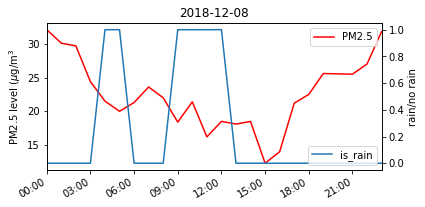

In [155]:
fig,ax = plt.subplots(figsize=(6,3))

day = '2018-12-08'
#plot the PM2.5 particle
pm_weather.loc[day,'PM2.5'].plot(color='red',ax=ax, legend='PM2.5 level')
ax.axes.set_ylabel('PM2.5 level ($\mu$g/m$^3$')
ax.legend(loc='upper right')
#format xaxis datetime
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
pm_weather.loc[day,'is_rain'].fillna(0).astype(int).plot(color='tab:blue',ax=ax2, legend='rain')
ax2.axes.set_ylabel('rain/no rain')
ax2.legend(loc='lower right')
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.title(day)

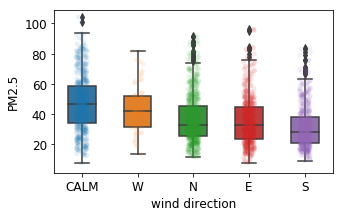

In [160]:
#set plt font size
plt.rcParams.update({'font.size': 12})

fig,ax = plt.subplots(figsize=(5,3))

# plot wind direction relationship with pm2.5
# select the data in winter
data = pm_weather.loc['2018-11-01':'2019-03-10']
data = pm_weather.query('season == "winter"')
# reduce the number of categories to simplify the plot
data = data[data['Wind'].isin(['CALM','N','W','E','S'])]

# sort the data by the mean pollution value
temp = data[['PM2.5','Wind']].groupby('Wind').agg(['mean','median','std']).dropna()
temp.columns = ['mean','median','std']
temp = temp.sort_values('median',ascending=False)
temp.head()

con ='Wind'
sns.catplot(data=data, x= con, y='PM2.5',alpha=0.1,order=temp.index,ax=ax) 
sns.boxplot(data=data, x=con, y='PM2.5',order=temp.index,width=0.5,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.axes.set_xlabel('wind direction')
plt.close(2)
#plt.title('winter wind')


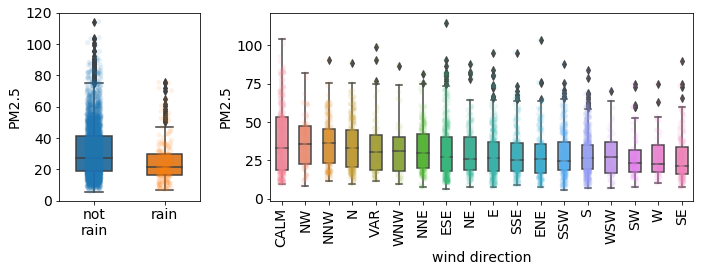

In [256]:
# plot rain relationship with pm2.5
data = pm_weather['2017-12-01':'2018-05-31']
fig,ax = plt.subplots(1,2,figsize=(10,4), gridspec_kw = {'width_ratios':[1, 3]})
cons = ['is_rain', 'Wind']
sns.catplot(data=data, x= cons[0], y='PM2.5',alpha=0.1, legend=False,ax=ax[0]) 
plt.close(2)
sns.boxplot(data=data,x=cons[0], y='PM2.5',ax=ax[0],width=0.5)
#close extra figure generated by sns
ax[0].axes.set_xticklabels(['not\nrain', 'rain'])
ax[0].axes.set_xlabel('')



# plot wind direction relationship with pm2.5
sns.catplot(data=data, x= cons[1], y='PM2.5',alpha=0.1,ax=ax[1],order=temp.index) 
plt.close(2)
sns.boxplot(data=data, x=cons[1], y='PM2.5',order=temp.index,ax=ax[1],width=0.5)
#sns.scatterplot(x=temp.index,y=temp['mean'],ax=ax[1],color='black',sizes=30,legend=False)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].axes.set_xlabel('wind direction')
#close extra figure generated by sns
plt.close(2)


plt.tight_layout()

In summary, I will keep the following columns: 'Temperature(C)', 'Humidity(%)',
'Wind Speed(kmh)', 'is_rain', 'is_calm', and 'Wind' (direction) columns.

## 3. Fire Map

NASA's Fire Information for Resource Management System (FIRM) monitors a real time fire activity with satellite.

Some information about the data. NASA's Fire Information for Resource Management System (FIRMS) provides nea real-time, world-wide, fire map of anomalous fire activities using VIIRS measurements and MODIS measurement from two satellites named Aqua and Terra.

The data composed of the following columns [reference](https://earthdata.nasa.gov/what-is-new-collection-6-modis-active-fire-data):
- Central of the fire (1 km resolution): 'latitude', 'longitude' 
- Date and Time:'acq_date','acq_time' in UTC, 'DayNight'
- Hotspots temperature:  'brightness'and 'brightness_t31' in Kelvin (different channels of measurements) 
- FRP: fire radiative power in MW

- Confidence: Confidence estimates range between 0 and 100% and are assigned one of the three fire classes (low-confidence fire, nominal-confidence fire, or high-confidence fire) only for the MODIS measurement.

other infos 

- actual pixel size is shown in 'Scan' and 'Track'

I reqested the data for Thailand, Laos, Cambodia, Myanmar. 

In [2]:
fire = pd.DataFrame()
for filename in glob('data/fire_map/*.csv'):
    fire = pd.concat([fire,pd.read_csv(
        filename,usecols=[0,1,2,5,6,12], skiprows=1,header=None,
    dtype=str)],sort=False)

fire.columns= ['latitude', 'longitude','brightness','acq_date','acq_time','power']

#convert data type
fire['latitude'] = fire['latitude'].astype(float)
fire['longitude'] = fire['longitude'].astype(float)
fire['brightness'] = fire['brightness'].astype(float)
fire['power'] = fire['power'].astype(float)

#sort value by date and time
fire = fire.sort_values(['acq_date','acq_time','latitude','longitude'])
# data for each region will include record from the neighbor countries
# so need to drop duplicate records
fire = fire.drop_duplicates()

In [4]:
fire.head(), fire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3230301 entries, 1083 to 99700
Data columns (total 6 columns):
latitude      float64
longitude     float64
brightness    float64
acq_date      object
acq_time      object
power         float64
dtypes: float64(4), object(2)
memory usage: 172.5+ MB


(      latitude  longitude  brightness    acq_date acq_time  power
 1083  13.51030  107.31780       300.4  2016-01-01     1434   27.6
 1084  18.44940   98.39540       301.0  2016-01-01     1613   18.8
 2454  21.51911  109.45049       301.1  2016-01-01     1739    0.7
 2451  21.51924  109.45177       303.6  2016-01-01     1739    0.6
 2453  21.56120  108.43876       302.5  2016-01-01     1739    1.1, None)

In [5]:
# function to change latitude and longitude to Mercator coordinate system 
#from https://wiki.openstreetmap.org/wiki/Mercator
import math

def merc_x(lon):
  r_major = 6378137.000 # unit:meter
  return r_major*math.radians(lon)

def merc_y(lat):
    lat += 0.08
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

In [6]:
#conver to mercator coordinate
fire['x_mer']= fire.longitude.apply(merc_x)
fire['y_mer']= fire.latitude.apply(merc_y)

#calculate distance from BKK
fire['dis2BKK'] = ((fire.x_mer - 11187764.6720111)**2 +(fire.y_mer - 1544967.92056433)**2)**0.5

#assemble datetime column \
fire['datetime'] = fire['acq_date'] + ' ' + fire['acq_time']
fire['datetime'] = pd.to_datetime(fire['datetime'],format='%Y-%m-%d %H%M',utc=True)

#convert to Bangkok time zone and remove time zone information
fire['datetime'] = fire['datetime'].dt.tz_convert('Asia/Bangkok')
fire['datetime'] = fire['datetime'].dt.tz_localize(None)
fire = fire.sort_values('datetime')

fire = fire.drop('acq_time',axis=1)

In [7]:
fire.to_csv('data/model/thfire.csv',index=False)

### Visualize hot spots

In [420]:
from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem, Label
)
from bokeh.models.markers import Asterisk
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot


In [424]:
# load the regional information with latitude and longitude information in 
# mercadian coordinate
region_df = pd.read_csv('data/model/region_info.csv',sep=';')

In [161]:
fire = pd.read_csv('data/model/thfire.csv')
fire = fire.drop(['latitude','longitude'],axis=1)
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire.set_index('datetime',inplace=True)
fire.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3230301 entries, 2016-01-01 10:42:00 to 2019-03-28 03:12:00
Data columns (total 6 columns):
brightness    float64
acq_date      object
power         float64
x_mer         float64
y_mer         float64
dis2BKK       float64
dtypes: float64(5), object(1)
memory usage: 172.5+ MB


In [11]:
fire.head()

brightness    acq_date  power         x_mer  \
datetime                                                           
2016-01-01 10:42:00       313.1  2016-01-01    5.4  1.164407e+07   
2016-01-01 10:42:00       317.0  2016-01-01    8.6  1.167415e+07   
2016-01-01 10:42:00       318.0  2016-01-01    9.8  1.116164e+07   
2016-01-01 10:42:00       327.3  2016-01-01   26.5  1.116316e+07   
2016-01-01 10:42:00       320.0  2016-01-01    9.2  1.146312e+07   

                            y_mer        dis2BKK  
datetime                                          
2016-01-01 10:42:00  1.865610e+06  557700.429616  
2016-01-01 10:42:00  1.934536e+06  623167.037895  
2016-01-01 10:42:00  1.923257e+06  379190.307905  
2016-01-01 10:42:00  1.923060e+06  378891.882049  
2016-01-01 10:42:00  1.918268e+06  463870.543894

In [423]:
output_notebook()

Loading BokehJS ...

In [426]:
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values
stepx = 3.5E5
stepy = 1*stepx

The picture below compare the hot spots on Jan 08, 2018 with low PM2.5 level(green), Feb 08, 2018 with high PM2.5 level(red), and off winter season May 5, 2018. Clearly, the number of hot spots are less on the day with less pollution, and the number of hot spots is much lower in winter season. These hot spots are from agricultural burning

Since the PM2.5 particle is an average over 24 hours, and the average wind speed is 10 km/hour. This mean, the fire from as far as 240 km will contribute to the current PM2.5 level. This means the hot spots with in the yellow circle, in the previous 24 hours will contribute to the current PM2.5. 240 km cover a large area all the way to Myanmar and Cambodia. Furthermore, the hot pots as far as 480 km away will reach Bangkok on the next day. 

In [427]:
day3 = '2018-01-08' 
day = '2018-02-08'
day2 = '2018-05-08'

# define the map size the map is in meter unit 
p = figure(x_range=(bkk_x-stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator", 
               title='Fire Map 2018', plot_width=500, plot_height=500,
           toolbar_location=None)
# add terrian map
p.add_tile(STAMEN_TERRAIN)

# add 10 kmline
p.line(x=[bkk_x + 0.1*stepx, bkk_x + 0.1*stepx +100E3] , y= [bkk_y - 0.7*stepy,bkk_y - 0.7*stepy],
      color='black',line_width=2)
# add 10 km text
kmline = Label(x=bkk_x + 0.15*stepx, y=bkk_y - 0.7*stepy,
                 text='100 km')
p.add_layout(kmline)

# add 240 km circle
p.circle(x=bkk_x,y=bkk_y, size=300, color='yellow', alpha=0.4)

#  Bangkok location          
glyph = Asterisk(x=bkk_x,y=bkk_y, size=8, line_color='black')
p.add_glyph(glyph) 

# Data on 8 Feb
source = ColumnDataSource(fire[day])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='red',
           legend='8 Feb 2018')

# Data on 8 Jan
source = ColumnDataSource(fire[day3])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='green',
           legend='8 Jan 2018')

# Data on 8 May
source = ColumnDataSource(fire[day2])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='blue',
           legend='8 May 2018')


p.legend.location = "bottom_left"


show(p)

In [584]:
export_png(p, filename="firemap2018.png")

'C:\\Users\\Benny\\Documents\\Fern\\BKK-AQI\\firemap2018.png'

To include the fire map into the model. I select the hot spots within the 240 km radius from Bangkok. Find the total sum for that particular hours. Shift the data by 12 hours, which is the average time lag for the 240 km radius data. Then, take the total sum over the 24 hours window. The same treatment is applied to  the hot spots in 240 - 480 km radius, and 480 - 720 km radius with different time lag.

In [429]:
day3 = '2018-01-08' 
day = '2018-02-08'
day2 = '2018-05-08'

# define the map size the map is in meter unit 
p = figure(x_range=(bkk_x-stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator", 
               title='Fire Map 2018', plot_width=500, plot_height=500,
           toolbar_location=None)
# add terrian map
p.add_tile(STAMEN_TERRAIN)

# add 10 kmline
p.line(x=[bkk_x + 0.1*stepx, bkk_x + 0.1*stepx +100E3] , y= [bkk_y - 0.7*stepy,bkk_y - 0.7*stepy],
      color='black',line_width=2)
# add 10 km text
kmline = Label(x=bkk_x + 0.15*stepx, y=bkk_y - 0.7*stepy,
                 text='100 km')
p.add_layout(kmline)

# add 240 km circle
p.circle(x=bkk_x,y=bkk_y, size=300, color='yellow', alpha=0.4)

#  Bangkok location          
glyph = Asterisk(x=bkk_x,y=bkk_y, size=10, line_color='black')
p.add_glyph(glyph) 

# Data on 8 Feb
source = ColumnDataSource(fire[day])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='red',
           legend='8 Feb 2018')

# Data on 8 Jan
source = ColumnDataSource(fire[day3])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='green',
           legend='8 Jan 2018')



p.legend.location = "bottom_left"


show(p)

In [430]:
export_png(p, filename="blog2/firemap2018.png")

'C:\\Users\\Benny\\Documents\\Fern\\BKK-AQI\\blog2\\firemap2018.png'

In [670]:
stepx = 3E5
stepy = 3*stepx

day = '2019-03-17'

# define the map size the map is in meter unit 
p = figure(x_range=(bkk_x-stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator", 
               title='March 17, 2019', plot_width=450, plot_height=600,
           toolbar_location=None)
# add terrian map
p.add_tile(STAMEN_TERRAIN)


# Data on 17 March 2019
source = ColumnDataSource(fire[day])
p.triangle(source=source,x='x_mer',y='y_mer', size=3, color='red')


show(p)

In [671]:
export_png(p, filename="blog2/firemap2019.png")

'C:\\Users\\Benny\\Documents\\Fern\\BKK-AQI\\blog2\\firemap2019.png'

### Feature Engineer Hot Spots

Separate the hot spots based on the distance from Bangkok: 240 km, 480 km and 720 km. Perform rolling aggregation over 24 hours period and shift each pollution level by a time lag. For 240 km, the shift is 12 hours, which is the average time lag of this mass, for the fire from 480 km, the time lag is 12 + 24 hours and for 720 km, the time lag is 12 + 48 hour. 

I can either use the sum of the fire power or count the number of hot spots. Make both types of aggregation. Both types of aggregation have the same relationship with the PM2.5, so I used the count aggregation for easy interpretation.

In [162]:
# find active fire with in 240 km from bkk 
fireclose = fire[fire['dis2BKK'].values < 240000]
# sum all the active fire in the same hour 
firehourly240 = fireclose.resample('H').agg({'power':['sum','count']})
firehourly240.columns = ['pwsum240','firecount240']
# shift the data by 12 hours
firehourly240 = firehourly240.shift(12)
# create a 24 hour rolling sum 
firehourlyroll240 = firehourly240.rolling(window=24).sum().dropna()

In [163]:
# find active fire with in 480 km from bkk 
fireclose48 = fire.query('240000 < dis2BKK < 480000')
# sum all the active fire in the same hour 
firehourly480 = fireclose48.resample('H').agg({'power':['sum','count']})
firehourly480.columns = ['pwsum480','firecount480']
# shift by 36 hours time lag 
firehourly480 = firehourly480.shift(36)
#  24 hours sum
firehourlyroll480 = firehourly480.rolling(window=24).sum().dropna()

In [164]:
# find active fire with in 720 0 from bkk 
fireclose72 = fire.query('480000 < dis2BKK < 720000')
#fireclose72 = fire[fire['dis2BKK'].values < 720000]
firehourly720 = fireclose72.resample('H').agg({'power':['sum','count']})
firehourly720.columns = ['pwsum720','firecount720']
# shift by 12 + 48 hours time lag 
firehourly720 = firehourly720.shift(60)
# 24 hours sum
firehourlyroll720 = firehourly720.rolling(window=24).sum().dropna()

In [165]:
# load pm2.5 data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',['PM2.5','level','color']]

In [166]:
# merge the fire data into a single df and combine with pm2.5 data for exploration
merge_list = [firehourlyroll240, firehourlyroll480, firehourlyroll720]

for df in merge_list:
    bkkpm = bkkpm.merge(df,left_index=True,
                                    right_index=True, how='left' )

In [474]:
bkkpm.head()

PM2.5      level   color  pwsum240  firecount240  \
datetime                                                                
2016-03-03 15:00:00   62.9  unhealthy     red    4115.2        1168.0   
2016-03-03 16:00:00   62.9  unhealthy     red    4115.2        1168.0   
2016-03-03 17:00:00   55.5  unhealthy  orange    4115.2        1168.0   
2016-03-03 18:00:00   55.5  unhealthy  orange    4115.2        1168.0   
2016-03-03 19:00:00   47.9   moderate  orange    4115.2        1168.0   

                     pwsum480  firecount480  pwsum720  firecount720  
datetime                                                             
2016-03-03 15:00:00   27581.7        4505.0   19269.3        1771.0  
2016-03-03 16:00:00   27581.7        4505.0   19269.3        1771.0  
2016-03-03 17:00:00   27581.7        4505.0   19269.3        1771.0  
2016-03-03 18:00:00   27581.7        4505.0   19269.3        1771.0  
2016-03-03 19:00:00   27581.7        4505.0   19269.3        1771.0

In [475]:
bkkpm.columns

Index(['PM2.5', 'level', 'color', 'pwsum240', 'firecount240', 'pwsum480',
       'firecount480', 'pwsum720', 'firecount720'],
      dtype='object')

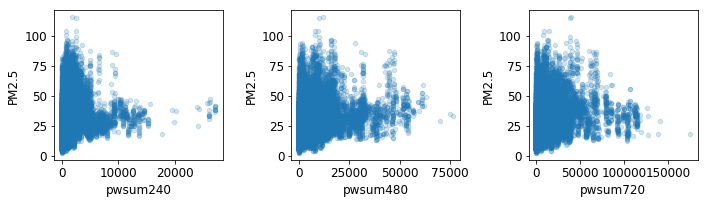

In [476]:
cols = ['pwsum240', 'pwsum480', 'pwsum720']

fig,axs = plt.subplots(1,3,figsize=(10,3))
axs = axs.reshape(-1)
for i, col in enumerate(cols):
    bkkpm.plot(x=col,y='PM2.5',ax=axs[i],kind='scatter', alpha=0.2)

plt.tight_layout()

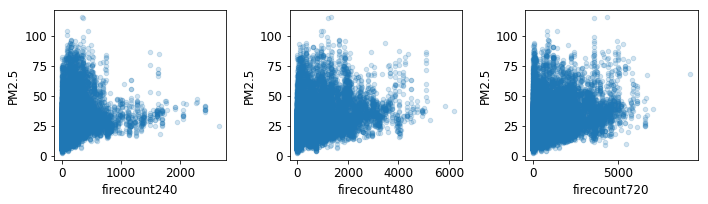

In [477]:
cols = ['firecount240', 'firecount480', 'firecount720']

fig,axs = plt.subplots(1,3,figsize=(10,3))
axs = axs.reshape(-1)
for i, col in enumerate(cols):
    bkkpm.plot(x=col,y='PM2.5',ax=axs[i],kind='scatter', alpha=0.2)

plt.tight_layout()

Text(0.5, 0, 'total fire power within 240 km')

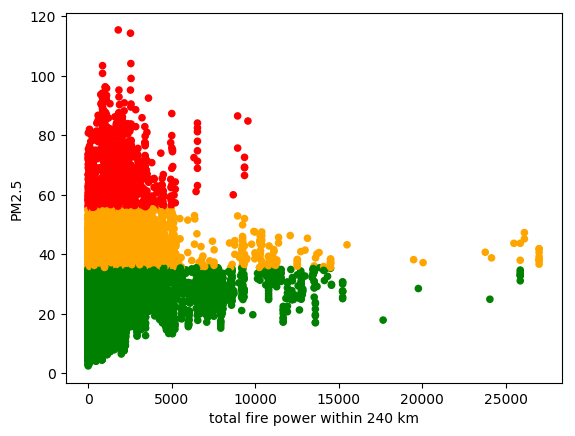

In [738]:
bkkpm.plot(x='pwsum240',y='PM2.5',color=bkkpm['color'],kind='scatter')
plt.xlabel('total fire power within 240 km')

The relationship is clearer when plotting in a log scale.

In [719]:
bkkpm[['log(1+pwsum240)', 'log(1+pwsum480)', 'log(1+pwsum720)']]= np.log(1+bkkpm[cols])

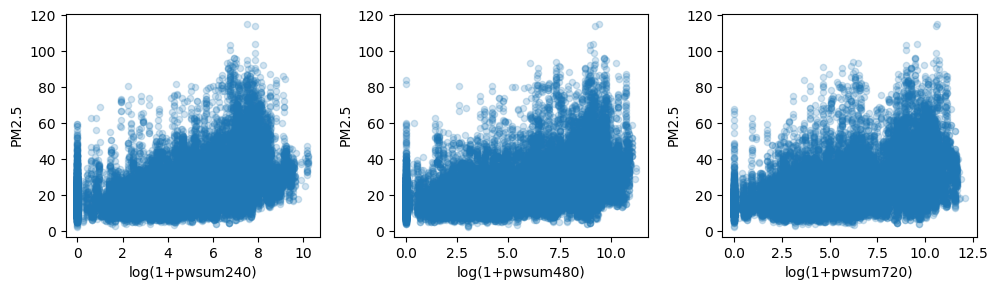

In [740]:
cols = ['log(1+pwsum240)', 'log(1+pwsum480)', 'log(1+pwsum720)']

fig,axs = plt.subplots(1,3,figsize=(10,3))
axs = axs.reshape(-1)
for i, col in enumerate(cols):
    bkkpm.plot(x=col,y='PM2.5',ax=axs[i],kind='scatter', alpha=0.2)
plt.tight_layout()

Text(0.5, 0, 'log (1+total fire in 240 km)')

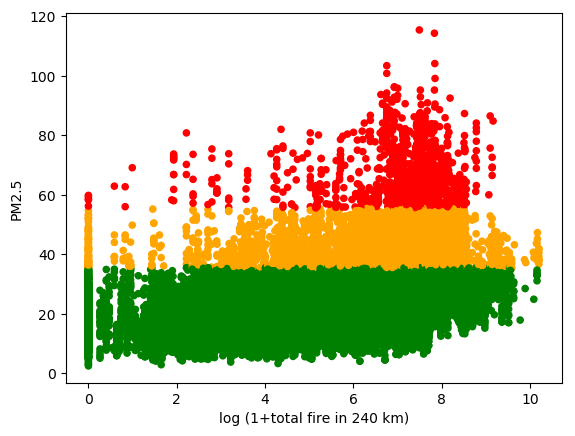

In [737]:
bkkpm.plot(x='log(1+pwsum240)',y='PM2.5',color=bkkpm['color'],kind='scatter')
plt.xlabel('log (1+total fire in 240 km)')

In [479]:
bkkpm[['log(1+firecount240)', 'log(1+firecount480)', 'log(1+firecount720)']]= np.log(1+bkkpm[cols])

Text(0.5, 0, 'log (1+total fire in 240 km)')

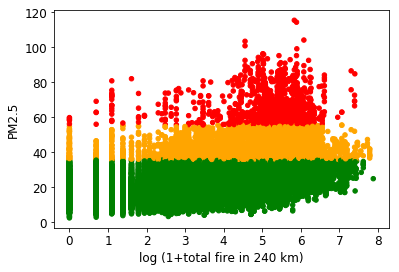

In [480]:
bkkpm.plot(x='log(1+firecount240)',y='PM2.5',color=bkkpm['color'],kind='scatter')
plt.xlabel('log (1+total fire in 240 km)')

The hot spots from 240, 480, and 720 km seems to have a log relationship with the PM2.5 level. Using either the count of the sum of fire power should work. I will put the count of hot spots into the models because it is easier to understand. I expected that the hot spots from further away should have less influence (lower importance). 

The fire map is very seasonal and align with the pollution seasonal pattern. 

In [736]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


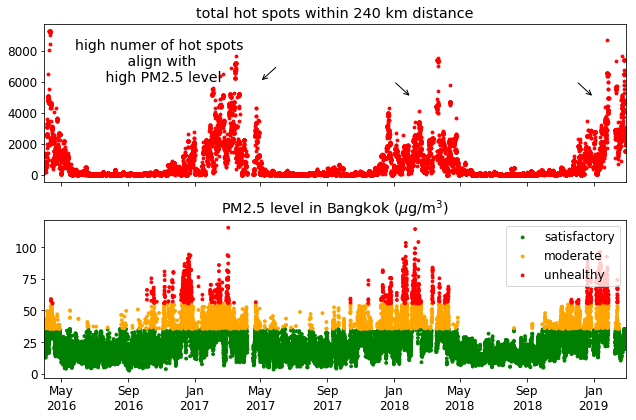

In [481]:
import matplotlib.dates as mdates

temp = bkkpm['2016-04':'2019-02'].copy()
temp['color'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])
temp['level'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate', 'unhealthy'])

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(9, 6),sharex=True)

ax1.scatter(x=temp.index,y=temp['pwsum240'],s=8,c='red')
ax1.set_title("total power hot spots within 240 km distance")
plt.xlim(temp.index.min(), temp.index.max())

ax1.text('2016-11', 6000, 'high numer of hot spots \n align with \n high PM2.5 level',
         {'color': 'k', 'fontsize': 14, 'ha': 'center'})
ax1.annotate("", xy=('2017-05',6000),xytext=('2017-06',7000),arrowprops=dict(arrowstyle="->"))
ax1.annotate("", xy=('2018-02',5000),xytext=('2018-01',6000),arrowprops=dict(arrowstyle="->"))
ax1.annotate("", xy=('2019-01',5000),xytext=('2018-12',6000),arrowprops=dict(arrowstyle="->"))


# make legend 
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    toplot = temp[temp['level']==legend]
    # plot the data for each pollution level
    ax2.scatter(toplot.index, toplot['PM2.5'], 
                c=toplot['color'],s=8, label=legend)
    
ax2.legend(loc='upper right')
ax2.set_title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

plt.tight_layout()

Text(0, 0.5, 'PM2.5 level')

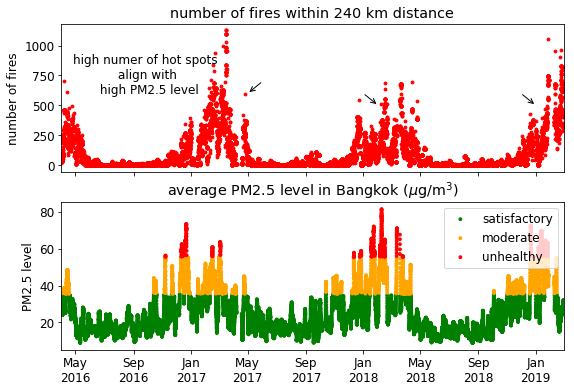

In [167]:
#set plt font size
plt.rcParams.update({'font.size': 12})

temp = bkkpm['2016-04':'2019-02'].copy()
temp['PM2.5'] = temp['PM2.5'].rolling(24,min_periods=0).mean()
temp['color'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])
temp['level'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate', 'unhealthy'])

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(9, 6),sharex=True)

ax1.scatter(x=temp.index,y=temp['firecount240'],s=8,c='red')
ax1.set_title("number of fires within 240 km distance")
plt.xlim(temp.index.min(), temp.index.max())
ax1.set_ylabel('number of fires')

ax1.text('2016-10', 600, 'high numer of hot spots \n align with \n high PM2.5 level',
         {'color': 'k', 'fontsize': 12, 'ha': 'center'})
ax1.annotate("", xy=('2017-05',600),xytext=('2017-06',700),arrowprops=dict(arrowstyle="->"))
ax1.annotate("", xy=('2018-02',500),xytext=('2018-01',600),arrowprops=dict(arrowstyle="->"))
ax1.annotate("", xy=('2019-01',500),xytext=('2018-12',600),arrowprops=dict(arrowstyle="->"))


# make legend 
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    toplot = temp[temp['level']==legend]
    # plot the data for each pollution level
    ax2.scatter(toplot.index, toplot['PM2.5'], 
                c=toplot['color'],s=8, label=legend)
    
ax2.legend(loc='upper right')
ax2.set_title("average PM2.5 level in Bangkok ($\mu$g/m$^3$)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
ax2.set_ylabel('PM2.5 level')

#plt.tight_layout()

In [15]:
firehourlyrollall = firehourlyroll240.merge(firehourlyroll480,left_index=True,
                                    right_index=True, how='right')

firehourlyrollall = firehourlyrollall.merge(firehourlyroll720,left_index=True,
                                    right_index=True, how='right')

In [498]:
firehourlyrollall.head()

pwsum240  firecount240  pwsum480  firecount480  pwsum720  \
datetime                                                                        
2016-01-04 21:00:00     874.6         201.0    5546.8         971.0   19595.3   
2016-01-04 22:00:00     874.6         201.0    6072.8        1017.0   14868.6   
2016-01-04 23:00:00     874.6         201.0    5828.5        1013.0   14868.6   
2016-01-05 00:00:00    1400.8         307.0    5378.2        1002.0   17659.2   
2016-01-05 01:00:00     640.8         184.0    7957.2        1148.0   10040.7   

                     firecount720  
datetime                           
2016-01-04 21:00:00        1708.0  
2016-01-04 22:00:00        1431.0  
2016-01-04 23:00:00        1431.0  
2016-01-05 00:00:00        1492.0  
2016-01-05 01:00:00        1123.0

In [496]:
firehourlyrollall.columns

Index(['pwsum240', 'firecount240', 'pwsum480', 'firecount480', 'pwsum720',
       'firecount720'],
      dtype='object')

In [497]:
firehourlyrollall[['firecount240','firecount480','firecount720']].to_csv('data/model/firehourlyroll.csv')


## 4. Traffic Data

Longdo traffic report traffic in the other of 0 - 10, when 10 mean bad traffic.

The raw data has some mistake on the date. The have some input on 2019/12/30, which is supposed to be for 2018/12/30. This was fixed by hand.
Some data is missing. This is fixed by linear interpolation

The maximum of the index seem to decrease after 2018, which is not likely from better traffic, but probably different calculation criteria. This means that the data probably not very useful. Fortunately, we can rely on other indications such as hour of day, day of week and holiday information to infer influence of traffic to PM2.5 level.

In [365]:
traffic = pd.read_csv('data/model/trafficindex.csv').drop('timestamp',axis=1)
traffic['datetime'] = pd.to_datetime(traffic['datetime'])

traffic = traffic.set_index('datetime').resample('H').mean().round(1)
traffic = traffic['2016':'2019']

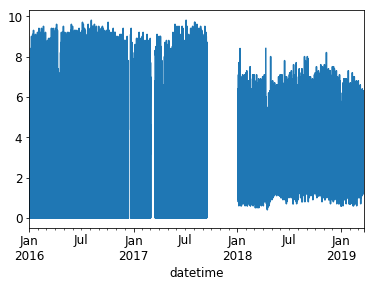

In [366]:
traffic['index'].plot()

In [368]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28230 entries, 2016-01-01 00:00:00 to 2019-03-22 05:00:00
Freq: H
Data columns (total 1 columns):
index    24876 non-null float64
dtypes: float64(1)
memory usage: 441.1 KB


In [406]:
print(traffic['2017'].max(),traffic['2018'].max())

index    9.8
dtype: float64 index    8.4
dtype: float64


In [632]:
#handle missing value by linear interpolation
traffic_proc = traffic.interpolate(method='linear')

In [634]:
traffic_proc.to_csv('data/model/traffic_proc.csv')

In [168]:
traffic = pd.read_csv('data/model/traffic_proc.csv')
traffic['datetime'] = pd.to_datetime(traffic['datetime'])
traffic = traffic.set_index('datetime')
traffic.head()

index
datetime                  
2016-01-01 00:00:00    0.5
2016-01-01 01:00:00    0.3
2016-01-01 02:00:00    0.2
2016-01-01 03:00:00    0.2
2016-01-01 04:00:00    0.2

In [169]:
# load pm2.5 data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',
                     ['PM2.5','level','color','season','is_holiday','is_weekend']]
bkkpm['TimeofDay'] = bkkpm.index.hour
bkkpm['year'] = bkkpm.index.year
bkkpm['month-year'] = bkkpm.index.strftime('%m-%Y')

In [332]:
bkkpm.head()

PM2.5      level   color season  is_holiday  is_weekend  \
datetime                                                                       
2016-03-03 15:00:00   62.9  unhealthy     red  other           0           0   
2016-03-03 16:00:00   62.9  unhealthy     red  other           0           0   
2016-03-03 17:00:00   55.5  unhealthy  orange  other           0           0   
2016-03-03 18:00:00   55.5  unhealthy  orange  other           0           0   
2016-03-03 19:00:00   47.9   moderate  orange  other           0           0   

                     TimeofDay  year month-year  
datetime                                         
2016-03-03 15:00:00         15  2016    03-2016  
2016-03-03 16:00:00         16  2016    03-2016  
2016-03-03 17:00:00         17  2016    03-2016  
2016-03-03 18:00:00         18  2016    03-2016  
2016-03-03 19:00:00         19  2016    03-2016

In [170]:
bkkpm = bkkpm.merge(traffic,left_index=True,
                                    right_index=True, how='left' )
bkkpm = bkkpm.dropna()

Is the traffic lower during holiday and weekend ? Yes ! 

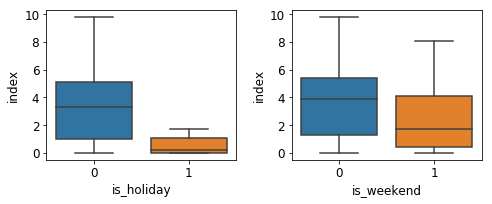

In [372]:
fig, ax = plt.subplots(1,2,figsize=(7,3))
sns.boxplot(data=bkkpm,x='is_holiday',y='index',ax=ax[0])
sns.boxplot(data=bkkpm,x='is_weekend',y='index',ax=ax[1])
plt.tight_layout()

Text(0.5, 0, 'time of day')

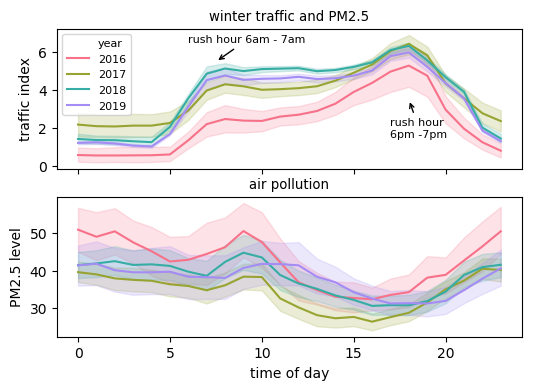

In [263]:
# traffic and time of day
fig,ax = plt.subplots(2,1, figsize=(6,4),sharex=True)
#set plt font size
plt.rcParams.update({'font.size': 8})


data = bkkpm.loc[bkkpm['season']=='winter']

# plot the traffic index vs hour of day
sns.lineplot(data=data,x='TimeofDay',y='index',hue='year',
            palette=sns.color_palette("husl", 4),ax=ax[0])
ax[0].axes.set_ylabel('traffic index')
ax[0].set_title('winter traffic and PM2.5')

#add annotation
ax[0].annotate('rush hour 6am - 7am',xy=(7.5,5.5), xytext=(6, 6.5),
                arrowprops=dict(facecolor='black',arrowstyle='->'))

#add annotation
ax[0].annotate('rush hour \n6pm -7pm',xy=(18,3.5), xytext=(17, 1.5),
                arrowprops=dict(facecolor='black',arrowstyle='->'))

#plot PM2.5 
sns.lineplot(data=data,x='TimeofDay',y='PM2.5',hue='year',
            palette=sns.color_palette("husl", 4),ax=ax[1],legend=False)
ax[1].set_title('air pollution')
ax[1].axes.set_ylabel('PM2.5 level')
ax[1].axes.set_xlabel('time of day')



Relationship between traffic and PM2.5

In [204]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

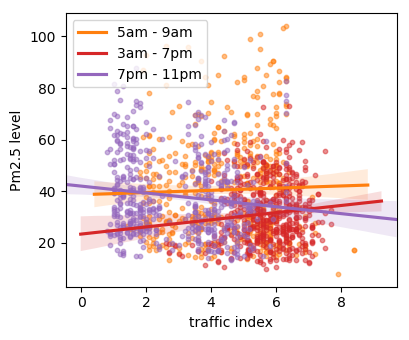

In [251]:
data = bkkpm.loc[bkkpm['season']=='winter'].loc['2018':'2019']

data['Time of Day'] = pd.cut(data['TimeofDay'],bins=[0,5,9,15,19,23],
                            labels=['early\nmorning','morning','noon','evening','night'])

data = data[data['Time of Day'].isin(['morning','evening','night'])]

fig = sns.lmplot(data=data, x='index',y='PM2.5',hue='Time of Day',
           scatter_kws={'alpha':0.5,'s':10},height=3.5, aspect=1.2,legend=False)
plt.legend([ '5am - 9am','3am - 7pm','7pm - 11pm'])
plt.xlabel('traffic index')
plt.ylabel('Pm2.5 level')
sns.despine(right=False,top=False)


In [225]:
bkkpm.columns

Index(['PM2.5', 'level', 'color', 'season', 'is_holiday', 'is_weekend',
       'TimeofDay', 'year', 'month-year', 'index'],
      dtype='object')

# Combine PM25, weather, traffic, firemap data

Using the datetime index of the PM2.5 data, I includes datetime features such as hour, dayofweek, is holiday, week of year in order to capture traffic and other human activities, which may not be included in the agricultural burning.

Additionally, the current pollution level would depends on the level in the previous hour, so I add the 24 hours rolling average of the pollution, shifted by an hour as one of the feature. Both PM2.5 levels columns are round to integer for simplicity.

In [16]:
#load the pollution data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')

# select Bangkok
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',['PM2.5','is_holiday','is_weekend','DayofWeek','weekofyear']]
#add hour of day
bkkpm['hour'] = bkkpm.index.hour

In [17]:
# make the prev level columns and shift the data by 1 hour
bkkpm['prev_level'] = bkkpm['PM2.5'].rolling(24).mean().shift(1)
bkkpm = bkkpm.dropna()
bkkpm['PM2.5'] = bkkpm['PM2.5'].round().astype(int)
bkkpm['prev_level'] = bkkpm['prev_level'].round().astype(int)

In [509]:
bkkpm.head(2)

PM2.5  is_holiday  is_weekend  DayofWeek  weekofyear  \
datetime                                                                    
2016-03-04 16:00:00     35           0           0          4           9   
2016-03-04 17:00:00     30           0           0          4           9   

                     hour  prev_level  
datetime                               
2016-03-04 16:00:00    16          44  
2016-03-04 17:00:00    17          42

In [18]:
# load traffic index
traffic = pd.read_csv('data/model/traffic_proc.csv')
traffic['datetime'] = pd.to_datetime(traffic['datetime'])
traffic = traffic.set_index('datetime').resample('H').mean()
traffic.head(2)

index
datetime                  
2016-01-01 00:00:00    0.5
2016-01-01 01:00:00    0.3

In [19]:
# load hot spot data 
firehour = pd.read_csv('data/model/firehourlyroll.csv')
firehour['datetime'] = pd.to_datetime(firehour['datetime'])
firehour = firehour.set_index('datetime')
firehour =  firehour.round(2)
firehour.head(2)

firecount240  firecount480  firecount720
datetime                                                     
2016-01-04 21:00:00         201.0         971.0        1708.0
2016-01-04 22:00:00         201.0        1017.0        1431.0

In [20]:
# load the weather data
weather = pd.read_csv('data/model/weatherall.csv').dropna()
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.set_index('date') 
weather[['Wind','Condition']] = weather[['Wind','Condition']].astype('category')
# keep four features 
weather = weather[['Wind','Temperature(C)', 'Humidity(%)','Wind Speed(kmh)','is_rain']]

In [21]:
weather.head(2)

Wind  Temperature(C)  Humidity(%)  Wind Speed(kmh)  \
date                                                                     
2016-01-01 00:00:00   NE            25.0           69         4.828032   
2016-01-01 00:30:00  NNE            25.0           65         8.046720   

                     is_rain  
date                          
2016-01-01 00:00:00        0  
2016-01-01 00:30:00        0

In [22]:
# merge pm data with the weather data
bkkpm_combo = bkkpm.merge(weather, how='left',left_index=True,right_index=True)
bkkpm_combo = bkkpm_combo.sort_index()
# weather data is missing in some hour, use forward fill to fix this problem
bkkpm_combo = bkkpm_combo.fillna(method='ffill')
bkkpm_combo.shape

(24430, 12)

In [23]:
# merge with the hotspot and traffic data
bkkpm_combo = bkkpm_combo.merge(firehour, how='left',left_index=True,right_index=True)
bkkpm_combo = bkkpm_combo.merge(traffic, how='left',left_index=True,right_index=True)

In [24]:
bkkpm_combo = bkkpm_combo.dropna()

In [25]:
bkkpm_combo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24430 entries, 2016-03-04 16:00:00 to 2019-03-20 20:00:00
Data columns (total 16 columns):
PM2.5              24430 non-null int32
is_holiday         24430 non-null int64
is_weekend         24430 non-null int64
DayofWeek          24430 non-null int64
weekofyear         24430 non-null int64
hour               24430 non-null int64
prev_level         24430 non-null int32
Wind               24430 non-null category
Temperature(C)     24430 non-null float64
Humidity(%)        24430 non-null float64
Wind Speed(kmh)    24430 non-null float64
is_rain            24430 non-null float64
firecount240       24430 non-null float64
firecount480       24430 non-null float64
firecount720       24430 non-null float64
index              24430 non-null float64
dtypes: category(1), float64(8), int32(2), int64(5)
memory usage: 2.8 MB


In [26]:
bkkpm_combo['Temperature(C)'] = bkkpm_combo['Temperature(C)'].round(2)
bkkpm_combo['Wind Speed(kmh)'] = bkkpm_combo['Wind Speed(kmh)'].round(2)

In [27]:
bkkpm_combo.head()

PM2.5  is_holiday  is_weekend  DayofWeek  weekofyear  \
2016-03-04 16:00:00     35           0           0          4           9   
2016-03-04 17:00:00     30           0           0          4           9   
2016-03-04 18:00:00     26           0           0          4           9   
2016-03-04 19:00:00     32           0           0          4           9   
2016-03-04 20:00:00     24           0           0          4           9   

                     hour  prev_level Wind  Temperature(C)  Humidity(%)  \
2016-03-04 16:00:00    16          44  SSW           33.89         46.0   
2016-03-04 17:00:00    17          42  SSW           33.89         46.0   
2016-03-04 18:00:00    18          41    S           32.22         55.0   
2016-03-04 19:00:00    19          40    S           30.00         62.0   
2016-03-04 20:00:00    20          39    S           28.89         70.0   

                     Wind Speed(kmh)  is_rain  firecount240  firecount480  \
2016-03-04 16:00:00            14.48      0.0         828.0        3194.0   
2016-03-04 17:00:00            12.87      0.0         828.0        3194.0   
2016-03-04 18:00:00            14.48      0.0         828.0        3194.0   
2016-03-04 19:00:00            14.48      0.0         828.0        3194.0   
2016-03-04 20:00:00            14.48      0.0         828.0        3194.0   

                     firecount720  index  
2016-03-04 16:00:00        3751.0    7.1  
2016-03-04 17:00:00        3751.0    8.2  
2016-03-04 18:00:00        3751.0    8.8  
2016-03-04 19:00:00        3751.0    8.6  
2016-03-04 20:00:00        3751.0    7.3

In [28]:
# save the data
bkkpm_combo.to_csv('data/model/bkkpm_combo_firecount.csv')

after putting everything in a single dataframe, I look for the redundant features

In [29]:
# load data
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo_firecount.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo.head(2)

datetime  PM2.5  is_holiday  is_weekend  DayofWeek  weekofyear  \
0 2016-03-04 16:00:00     35           0           0          4           9   
1 2016-03-04 17:00:00     30           0           0          4           9   

   hour  prev_level Wind  Temperature(C)  Humidity(%)  Wind Speed(kmh)  \
0    16          44  SSW           33.89         46.0            14.48   
1    17          42  SSW           33.89         46.0            12.87   

   is_rain  firecount240  firecount480  firecount720  index  
0      0.0         828.0        3194.0        3751.0    7.1  
1      0.0         828.0        3194.0        3751.0    8.2

In [30]:
from scipy.cluster import hierarchy as hc

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


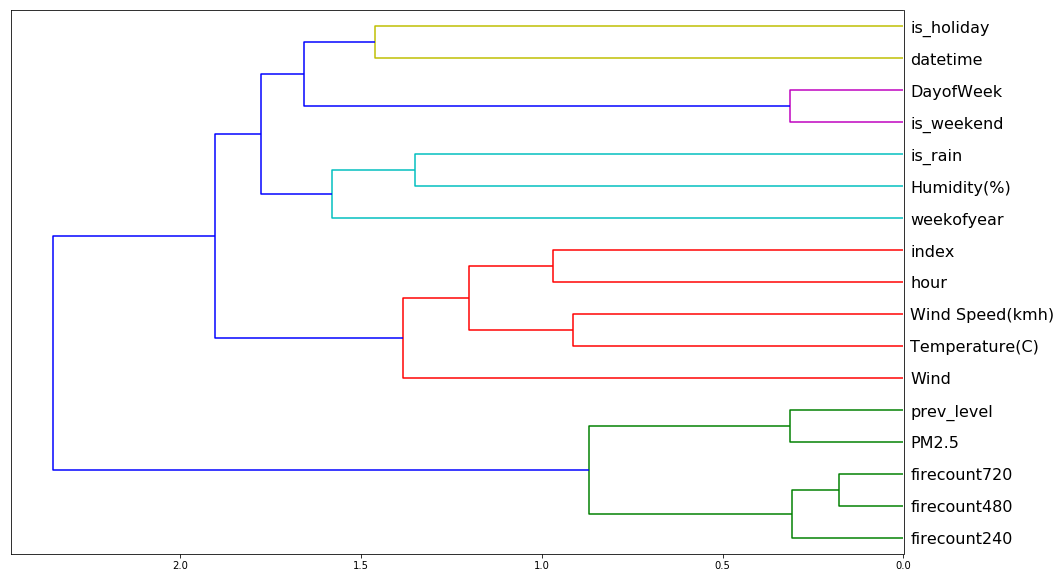

In [31]:
# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(bkkpm_combo).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=bkkpm_combo.columns, orientation='left', leaf_font_size=16)
plt.show()

Traffic index and hour of day has some relationship.

# ML model 

Care must be taken when dealing with the time series data. Especially, the train-test split cannot be done with a random shuffle. The data has to be separated by time. This is how I split the data.

Test data is between 2019-02-01 to 2019-03-19. For the rest of the data, I allocate the first 80% for training and 20% for the validation. 

This is my analysis step:
1. I use random forest regression to rank most important features, drop features with low feature of important to improve the model.
2. Drop feature, which is redundant to see if the prediction accuracy improve
3. Use the final feature for auto ML to hunt for the best algorithm. (On a separate notebook)
4. Reproduce the result here, use the entire data set to train the model, calculate permutation-based feature of importances.

In [770]:
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)

In [771]:
#print score print out rmse, and r2 score
def print_score(m):
    res = [mean_squared_error(m.predict(X_trn), y_trn), mean_squared_error(m.predict(X_val), y_val),
                m.score(X_trn, y_trn), m.score(X_val, y_val)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [772]:
# load data
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo_firecount.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo = bkkpm_combo.dropna()
bkkpm_combo.head()

datetime  PM2.5  is_holiday  is_weekend  DayofWeek  weekofyear  \
0 2016-03-04 16:00:00     35           0           0          4           9   
1 2016-03-04 17:00:00     30           0           0          4           9   
2 2016-03-04 18:00:00     26           0           0          4           9   
3 2016-03-04 19:00:00     32           0           0          4           9   
4 2016-03-04 20:00:00     24           0           0          4           9   

   hour  prev_level Wind  Temperature(C)  Humidity(%)  Wind Speed(kmh)  \
0    16          44  SSW           33.89         46.0            14.48   
1    17          42  SSW           33.89         46.0            12.87   
2    18          41    S           32.22         55.0            14.48   
3    19          40    S           30.00         62.0            14.48   
4    20          39    S           28.89         70.0            14.48   

   is_rain  firecount240  firecount480  firecount720  index  
0      0.0         828.0        3194.0        3751.0    7.1  
1      0.0         828.0        3194.0        3751.0    8.2  
2      0.0         828.0        3194.0        3751.0    8.8  
3      0.0         828.0        3194.0        3751.0    8.6  
4      0.0         828.0        3194.0        3751.0    7.3

In [773]:
print(bkkpm_combo['datetime'].min(), bkkpm_combo['datetime'].max())

2016-03-04 16:00:00 2019-03-20 20:00:00


In [774]:
bkkpm_combo.columns

Index(['datetime', 'PM2.5', 'is_holiday', 'is_weekend', 'DayofWeek',
       'weekofyear', 'hour', 'prev_level', 'Wind', 'Temperature(C)',
       'Humidity(%)', 'Wind Speed(kmh)', 'is_rain', 'firecount240',
       'firecount480', 'firecount720', 'index'],
      dtype='object')

In [775]:
to_cat = ['Wind']
for cat in to_cat:
    bkkpm_combo[cat] = bkkpm_combo[cat].astype('category')
    print(bkkpm_combo[cat].unique())

[SSW, S, SSE, SE, ESE, ..., NE, VAR, NNE, NW, N]
Length: 18
Categories (18, object): [SSW, S, SSE, SE, ..., VAR, NNE, NW, N]


In [776]:
# test index start at 
test_idx = bkkpm_combo[bkkpm_combo['datetime'] > '2019-01-31'].index[0]

In [777]:
#separate data for training and testing 
test = bkkpm_combo.iloc[test_idx:]
to_train = bkkpm_combo.iloc[:test_idx]

In [778]:
#put the training set into proc_df, indicate the target column
# one hot encode the wind column with 18 catergory
df, y, nas = proc_df(to_train, 'PM2.5',max_n_cat=18, skip_flds=['datetime','weekofyear'])

In [779]:
df.columns

Index(['is_holiday', 'is_weekend', 'DayofWeek', 'hour', 'prev_level',
       'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmh)', 'is_rain',
       'firecount240', 'firecount480', 'firecount720', 'index', 'Wind_CALM',
       'Wind_E', 'Wind_ENE', 'Wind_ESE', 'Wind_N', 'Wind_NE', 'Wind_NNE',
       'Wind_NNW', 'Wind_NW', 'Wind_S', 'Wind_SE', 'Wind_SSE', 'Wind_SSW',
       'Wind_SW', 'Wind_VAR', 'Wind_W', 'Wind_WNW', 'Wind_WSW', 'Wind_nan'],
      dtype='object')

In [780]:
# calculate the train & validation split index
idx = int(df.shape[0]*0.8)
idx

18820

In [781]:
# train and validation split
X_trn = df.iloc[:idx]
X_val = df.iloc[idx:]

y_trn = y[:idx]
y_val = y[idx:]

In [782]:
# rf after hyper parameter tuning
m = RandomForestRegressor(n_estimators=100, 
                          min_samples_split= 2,
                          min_samples_leaf= 1,
                          max_features= 1,
                          max_depth= None, bootstrap= False, 
                          n_jobs=-1)
m.fit(X_trn, y_trn)
res = print_score(m)

[0.02137616403522089, 77.13436173013945, 0.9998902420207304, 0.6555806585762496]


In [156]:
param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}

Tuning the 'max_feature' columns does improve the model accuracy, but the model would put all weight into the previous level data, which is not the purpose of this study; therefore I omitted this parameter in the hyper parameters search.

In [157]:
#hyper parameter tuning
search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=42)

In [158]:
search.fit(X_trn,y_trn)
search.best_params_, search.best_score_

({'n_estimators': 100,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_depth': None,
  'bootstrap': False},
 0.546157935709967)

Rerun the rf model using these parameters.

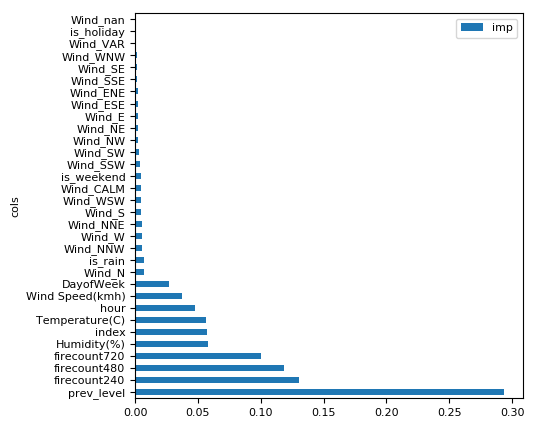

In [324]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,5))

In [284]:
fi

cols       imp
4        prev_level  0.268520
10     firecount480  0.128281
9      firecount240  0.121851
11     firecount720  0.111357
6       Humidity(%)  0.062332
12            index  0.059122
5    Temperature(C)  0.058503
3              hour  0.048999
7   Wind Speed(kmh)  0.038892
2         DayofWeek  0.027415
17           Wind_N  0.006491
8           is_rain  0.006256
20         Wind_NNW  0.005484
19         Wind_NNE  0.005477
28           Wind_W  0.005354
30         Wind_WSW  0.005182
22           Wind_S  0.005148
1        is_weekend  0.004797
25         Wind_SSW  0.004739
13        Wind_CALM  0.004453
26          Wind_SW  0.002735
21          Wind_NW  0.002714
18          Wind_NE  0.002517
14           Wind_E  0.002482
16         Wind_ESE  0.002203
15         Wind_ENE  0.002034
24         Wind_SSE  0.001902
29         Wind_WNW  0.001486
23          Wind_SE  0.001453
27         Wind_VAR  0.001159
0        is_holiday  0.000663
31         Wind_nan  0.000000

In [785]:
# custom made feature of importance based on permutation method
def feat_importance(m, x_trn, y_trn, metric=accuracy_score):
    """ Computes the feature importance for any model
    m is the model
    x_trn is the training data
    metric is the accuracy_score
    """
    baseline = metric(y_trn, m.predict(x_trn))
    imp = []
    imp_std = []
    for col in x_trn.columns:
        tempt = x_trn.copy()
        shuffle = []
        # ten iteration to get better statistic
        for i in range(10):
            tempt[col] = np.random.RandomState(seed=42).permutation(tempt[col])
            shuffle_score = metric(y_trn, m.predict(tempt))
            shuffle.append(-(baseline - shuffle_score)/baseline)
        imp.append(np.mean(shuffle))
        imp_std.append(np.std(shuffle))
    fea_imp = pd.DataFrame({'cols': x_trn.columns, 'imp':imp,'imp_std':imp_std})
    return fea_imp.sort_values('imp', ascending=False)

In [325]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)


cols          imp    imp_std
4        prev_level  3611.414583  26.849992
9      firecount240  1311.807209  14.899282
10     firecount480   951.241425  10.136441
11     firecount720   816.201031   5.773810
2         DayofWeek   753.478698   8.216908
6       Humidity(%)   678.299417  10.359066
7   Wind Speed(kmh)   650.032637  10.793829
3              hour   624.903537   5.886591
12            index   564.405057   6.866549
5    Temperature(C)   528.712593   7.031627
1        is_weekend   443.645006   9.376477
22           Wind_S   236.146176   5.048099
8           is_rain   187.171219   6.527849
25         Wind_SSW   149.946321   2.535773
13        Wind_CALM   140.925832   2.932038
17           Wind_N   126.034903   2.394102
16         Wind_ESE   117.513267   2.164973
20         Wind_NNW   110.607089   3.000715
28           Wind_W   109.062618   2.519737
19         Wind_NNE   103.115412   1.586619
14           Wind_E   102.818794   2.396958
30         Wind_WSW    96.743266   2.294175
24         Wind_SSE    87.329970   3.980633
15         Wind_ENE    79.730761   3.412683
23          Wind_SE    74.481972   2.611009
18          Wind_NE    68.054247   1.791655
26          Wind_SW    65.685262   2.408435
21          Wind_NW    63.779204   2.221364
29         Wind_WNW    50.925325   2.473108
27         Wind_VAR    28.125288   0.652321
0        is_holiday     5.934736   0.494786
31         Wind_nan     0.000000   0.000000

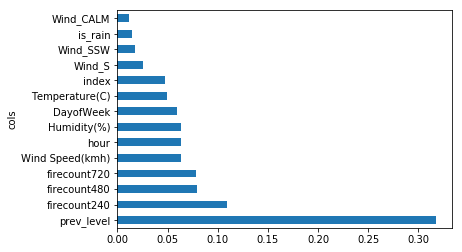

In [786]:
# use the normalized feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()
fi_per.plot('cols', 'imp', 'barh', legend=False)

For the first four features, permutation-based feature of importance is in agreement with the build-in function. They disagree on the later parts. Looking at the result, I tend to agree with my custom function.

Another reason to use my own feature of importance function is that I can reuse this later after I obtain the best model from TPOT.

In [329]:
fi_per

cols       imp    imp_std
4        prev_level  0.279126  26.849992
9      firecount240  0.101390  14.899282
10     firecount480  0.073522  10.136441
11     firecount720  0.063084   5.773810
2         DayofWeek  0.058236   8.216908
6       Humidity(%)  0.052426  10.359066
7   Wind Speed(kmh)  0.050241  10.793829
3              hour  0.048299   5.886591
12            index  0.043623   6.866549
5    Temperature(C)  0.040864   7.031627
1        is_weekend  0.034289   9.376477
22           Wind_S  0.018252   5.048099
8           is_rain  0.014466   6.527849
25         Wind_SSW  0.011589   2.535773
13        Wind_CALM  0.010892   2.932038
17           Wind_N  0.009741   2.394102
16         Wind_ESE  0.009083   2.164973
20         Wind_NNW  0.008549   3.000715
28           Wind_W  0.008429   2.519737
19         Wind_NNE  0.007970   1.586619
14           Wind_E  0.007947   2.396958
30         Wind_WSW  0.007477   2.294175
24         Wind_SSE  0.006750   3.980633
15         Wind_ENE  0.006162   3.412683
23          Wind_SE  0.005757   2.611009
18          Wind_NE  0.005260   1.791655
26          Wind_SW  0.005077   2.408435
21          Wind_NW  0.004929   2.221364
29         Wind_WNW  0.003936   2.473108
27         Wind_VAR  0.002174   0.652321
0        is_holiday  0.000459   0.494786
31         Wind_nan  0.000000   0.000000

In [814]:
# drop features with low importance 
to_drop = fi_per[fi_per.imp <0.01].cols
df_drop = df.drop(to_drop,axis=1)

In [788]:
df_drop.head()

is_holiday  is_weekend  DayofWeek  hour  prev_level  Temperature(C)  \
0           0           0          4    16          44           33.89   
1           0           0          4    17          42           33.89   
2           0           0          4    18          41           32.22   
3           0           0          4    19          40           30.00   
4           0           0          4    20          39           28.89   

   Humidity(%)  Wind Speed(kmh)  is_rain  firecount240  ...  Wind_S  Wind_SE  \
0         46.0            14.48      0.0         828.0  ...       0        0   
1         46.0            12.87      0.0         828.0  ...       0        0   
2         55.0            14.48      0.0         828.0  ...       1        0   
3         62.0            14.48      0.0         828.0  ...       1        0   
4         70.0            14.48      0.0         828.0  ...       1        0   

   Wind_SSE  Wind_SSW  Wind_SW  Wind_VAR  Wind_W  Wind_WNW  Wind_WSW  Wind_nan  
0         0         1        0         0       0         0         0         0  
1         0         1        0         0       0         0         0         0  
2         0         0        0         0       0         0         0         0  
3         0         0        0         0       0         0         0         0  
4         0         0        0         0       0         0         0         0  

[5 rows x 32 columns]

In [815]:
df_drop.columns

Index(['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'firecount240', 'firecount480',
       'firecount720', 'index', 'Wind_CALM', 'Wind_S', 'Wind_SSW'],
      dtype='object')

In [816]:
idx = 17661
X_trn = df_drop.iloc[:idx]
X_val = df_drop.iloc[idx:]

y_trn = y[:idx]
y_val = y[idx:]

In [817]:
# with some feature drop
m = RandomForestRegressor(n_estimators=100, 
                          min_samples_split= 2,
                          min_samples_leaf= 1,
                          max_features= 1,
                          max_depth= None, bootstrap= False, 
                          n_jobs=-1)
m.fit(X_trn, y_trn)
res = print_score(m)

[0.009625729007417474, 64.02721531245383, 0.9999513344534228, 0.6688866864601279]


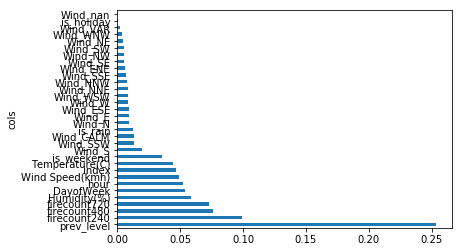

In [791]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()
fi_per.plot('cols', 'imp', 'barh', legend=False)

List features

In [336]:
df_drop.columns

Index(['is_weekend', 'DayofWeek', 'hour', 'prev_level', 'Temperature(C)',
       'Humidity(%)', 'Wind Speed(kmh)', 'is_rain', 'firecount240',
       'firecount480', 'firecount720', 'index', 'Wind_CALM', 'Wind_S',
       'Wind_SSW'],
      dtype='object')

### Retrain using the entire dataset

Since the purpose of this study is to understand the sources of the pollution in the past, I focus on the accuracy of the training set. The model does overfit, but I think this current treatment is suitable for the purpose of this study.  

In [829]:
#put the training set into proc_df, indicate the target column
df, y, nas = proc_df(bkkpm_combo, 'PM2.5',max_n_cat=18, skip_flds=['datetime','weekofyear'])


In [830]:
df.columns

Index(['is_holiday', 'is_weekend', 'DayofWeek', 'hour', 'prev_level',
       'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmh)', 'is_rain',
       'firecount240', 'firecount480', 'firecount720', 'index', 'Wind_CALM',
       'Wind_E', 'Wind_ENE', 'Wind_ESE', 'Wind_N', 'Wind_NE', 'Wind_NNE',
       'Wind_NNW', 'Wind_NW', 'Wind_S', 'Wind_SE', 'Wind_SSE', 'Wind_SSW',
       'Wind_SW', 'Wind_VAR', 'Wind_W', 'Wind_WNW', 'Wind_WSW', 'Wind_nan'],
      dtype='object')

In [831]:
df = df[['DayofWeek', 'hour', 'prev_level', 'Temperature(C)',
       'Humidity(%)', 'Wind Speed(kmh)', 'is_rain', 'firecount240',
       'firecount480', 'firecount720', 'index', 'Wind_CALM', 'Wind_S',
       'Wind_SSW']] 

In [832]:
# train and validation split
X_trn = df 
#X_val = df.iloc[test_idx:]

y_trn = y
#y_val = y[test_idx:]

In [833]:
# with some feature drop
m = RandomForestRegressor(n_estimators=100, 
                          min_samples_split= 2,
                          min_samples_leaf= 1,
                          max_features= 1,
                          max_depth= None, bootstrap= False, 
                          n_jobs=-1)
m.fit(X_trn, y_trn)
print(mean_squared_error(m.predict(X_trn), y_trn), m.score(X_trn, y_trn))

0.016352844862873517 0.9999170556399963


In [842]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp_std'] = fi_per['imp_std']/fi_per['imp'].sum()
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()

In [843]:
fi_per

cols       imp   imp_std
2        prev_level  0.322542  0.003115
7      firecount240  0.097736  0.000746
8      firecount480  0.086989  0.000928
9      firecount720  0.081322  0.000943
0         DayofWeek  0.065862  0.000800
1              hour  0.065026  0.000546
4       Humidity(%)  0.060992  0.000518
3    Temperature(C)  0.051578  0.000617
5   Wind Speed(kmh)  0.051342  0.000578
10            index  0.047227  0.000387
12           Wind_S  0.023770  0.001068
13         Wind_SSW  0.018562  0.000413
6           is_rain  0.013755  0.000540
11        Wind_CALM  0.013296  0.000293

In [454]:
fi_per.cols

2          prev_level
7        firecount240
8        firecount480
9        firecount720
4         Humidity(%)
1                hour
0           DayofWeek
5     Wind Speed(kmh)
3      Temperature(C)
10              index
12             Wind_S
13           Wind_SSW
6             is_rain
11          Wind_CALM
Name: cols, dtype: object

In [799]:
fi_per['cols'] = ['previous PM 2.5\nlevel', 'fire 240 km', 'fire 240-480 km', 'fire 480-720 km',
                  'Humidity(%)','hour of day','DayofWeek','Wind Speed(kmh)','Temperature(C)','traffic index',
                  'Wind South','Wind Southwest','is Rain', 'Wind Calm']
fi_per = fi_per.sort_values('imp')

Text(0.5, 0, '% importance')

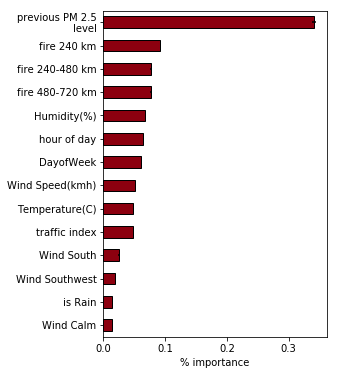

In [800]:
fi_per.plot('cols', 'imp', 'barh', xerr='imp_std' ,legend=False,figsize=(4,6),
           color='xkcd:crimson',linewidth=1,edgecolor='black')
plt.ylabel(None)
plt.xlabel('% importance')

In [219]:
# save the rf model
from joblib import dump, load
dump(m, 'data/model/rfmodel.joblib') 

['data/model/rfmodel.joblib']

In [ ]:
m = load('data/model/rfmodel.joblib')

In [373]:
df.columns

Index(['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'firecount240', 'firecount480',
       'firecount720', 'index', 'Wind_CALM', 'Wind_S', 'Wind_SSW'],
      dtype='object')

In [996]:
temp = df.copy()
temp.columns = [ 'Day of Week', 'hour of day', 'previous PM 2.5\nlevel', 
              'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmh)', ' is rain','fire 240 km', 'fire 240-480 km', 'fire 480-720 km',
                  'traffic index', 'Wind Calm', 'Wind South','Wind Southwest']

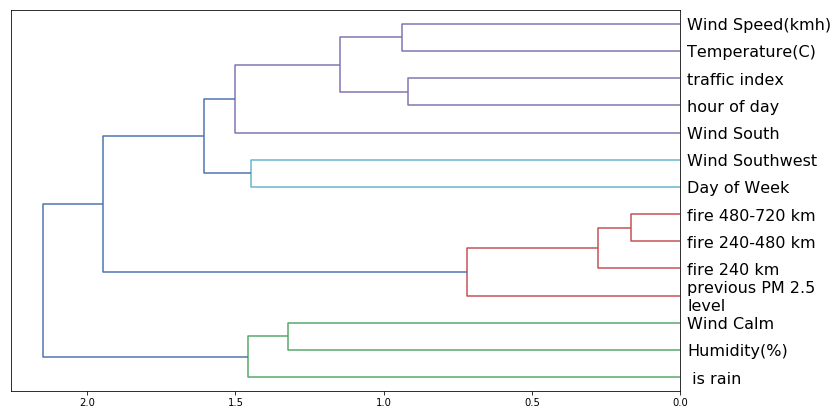

In [997]:
# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(temp).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(12,7))
dendrogram = hc.dendrogram(z, labels=temp.columns, orientation='left', leaf_font_size=16)
plt.show()

In summary, using random forest regression, I achieve 66% accuracy on the test set, and 00% on the training set. Using the training set, I can rank the feature of importance. 

Note that one can improve the accuracy on the model by putting more weight on the pollution level from the previous hour, but the model is not very useful for interpretation. 

# Interpretation

In [378]:
from treeinterpreter import treeinterpreter as ti

In [479]:
# find the max and min PM2.5 values in 2019
bkkpm_combo[bkkpm_combo['datetime']>='2019-01'].describe()

PM2.5   is_holiday   is_weekend    DayofWeek   weekofyear  \
count  1544.000000  1544.000000  1544.000000  1544.000000  1544.000000   
mean     35.904145     0.001295     0.290803     2.981865     6.378886   
std      15.668384     0.035979     0.454280     2.002509     3.515852   
min      10.000000     0.000000     0.000000     0.000000     1.000000   
25%      26.000000     0.000000     0.000000     1.000000     3.000000   
50%      32.000000     0.000000     0.000000     3.000000     7.000000   
75%      42.250000     0.000000     1.000000     5.000000     9.000000   
max      96.000000     1.000000     1.000000     6.000000    12.000000   

              hour   prev_level  Temperature(C)  Humidity(%)  Wind Speed(kmh)  \
count  1544.000000  1544.000000     1544.000000  1544.000000      1544.000000   
mean     11.483808    35.897021       29.094883    67.983808        10.982001   
std       6.895366    12.853646        3.184439    15.921075         5.205861   
min       0.000000    15.000000       21.110000    17.000000         0.000000   
25%       6.000000    26.000000       27.220000    55.000000         8.050000   
50%      11.000000    32.000000       28.890000    70.000000        11.270000   
75%      17.000000    44.000000       32.220000    79.000000        14.480000   
max      23.000000    70.000000       37.780000   100.000000        27.360000   

           is_rain  firecount240  firecount480  firecount720        index  
count  1544.000000   1544.000000   1544.000000   1544.000000  1544.000000  
mean      0.005181    487.150907   1531.625648   1921.072539     3.599870  
std       0.071818    431.815892    858.219807    958.344235     1.787872  
min       0.000000      2.000000     27.000000     32.000000     0.600000  
25%       0.000000    218.750000    905.500000   1376.750000     1.600000  
50%       0.000000    362.000000   1347.000000   1786.000000     4.200000  
75%       0.000000    639.250000   1865.000000   2381.000000     5.000000  
max       1.000000   2642.000000   6214.000000   5400.000000     7.300000

In [474]:
bkkpm_combo[bkkpm_combo['PM2.5']==96]

datetime  PM2.5  is_holiday  is_weekend  DayofWeek  \
23177 2019-01-13 08:00:00     96           0           1          6   
23178 2019-01-13 09:00:00     96           0           1          6   
23179 2019-01-13 10:00:00     96           0           1          6   

       weekofyear  hour  prev_level Wind  Temperature(C)  Humidity(%)  \
23177           2     8          62  ENE           27.22         74.0   
23178           2     9          63    E           28.89         62.0   
23179           2    10          65    E           31.11         55.0   

       Wind Speed(kmh)  is_rain  firecount240  firecount480  firecount720  \
23177             8.05      0.0         150.0        1649.0         896.0   
23178            14.48      0.0         150.0        1649.0         895.0   
23179            14.48      0.0         153.0        1632.0         921.0   

       index  
23177    2.6  
23178    3.3  
23179    3.7

In [480]:
bkkpm_combo[bkkpm_combo['PM2.5']==10].tail()

datetime  PM2.5  is_holiday  is_weekend  DayofWeek  \
21324 2018-10-21 06:00:00     10           0           1          6   
21335 2018-10-21 17:00:00     10           0           1          6   
21336 2018-10-21 18:00:00     10           0           1          6   
21760 2018-11-08 19:00:00     10           0           0          3   
23771 2019-02-19 19:00:00     10           0           0          1   

       weekofyear  hour  prev_level Wind  Temperature(C)  Humidity(%)  \
21324          42     6          23  ESE           26.11        100.0   
21335          42    17          16  SSE           27.22         94.0   
21336          42    18          16   SE           26.11         94.0   
21760          45    19          24  ENE           28.89         74.0   
23771           8    19          16    S           30.00         62.0   

       Wind Speed(kmh)  is_rain  firecount240  firecount480  firecount720  \
21324             4.83      1.0           2.0           3.0          12.0   
21335            12.87      1.0           2.0           3.0          11.0   
21336             9.66      1.0           2.0           3.0          11.0   
21760             9.66      0.0           7.0          45.0          44.0   
23771            12.87      0.0         276.0        1008.0        1755.0   

       index  
21324    2.2  
21335    5.0  
21336    5.1  
21760    5.9  
23771    4.4

Try to interpret the tree on 2019-01-13 (index = 23177) and 2019-02-19 index 23771

In [834]:
X_trn.columns

Index(['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'firecount240', 'firecount480',
       'firecount720', 'index', 'Wind_CALM', 'Wind_S', 'Wind_SSW'],
      dtype='object')

In [844]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp_std'] = fi_per['imp_std']/fi_per['imp'].sum()
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()

In [845]:
fi_per

cols       imp   imp_std
2        prev_level  0.322542  0.003115
7      firecount240  0.097736  0.000746
8      firecount480  0.086989  0.000928
9      firecount720  0.081322  0.000943
0         DayofWeek  0.065862  0.000800
1              hour  0.065026  0.000546
4       Humidity(%)  0.060992  0.000518
3    Temperature(C)  0.051578  0.000617
5   Wind Speed(kmh)  0.051342  0.000578
10            index  0.047227  0.000387
12           Wind_S  0.023770  0.001068
13         Wind_SSW  0.018562  0.000413
6           is_rain  0.013755  0.000540
11        Wind_CALM  0.013296  0.000293

In [859]:
idx = 23177
row = X_trn.iloc[idx].values
prediction, bias, contributions = ti.predict(m, row.reshape(1, -1))

In [860]:
prediction[0], bias[0]

(array([96.]), 25.558534588620557)

In [861]:
bias_df = pd.DataFrame({'feature':'bias','value':bias[0],'contribution':bias[0]},index =[0])
bias_df = bias_df.set_index('feature')

In [862]:
inter_df = pd.concat([pd.DataFrame(X_trn.iloc[idx]).reset_index(),pd.Series(contributions[0])],
           ignore_index=True,axis=1)
inter_df.columns = ['feature','value','contribution']
inter_df = inter_df.set_index('feature')
#order by feature of importance
inter_df = inter_df.reindex(fi_per.cols)
inter_df = pd.concat([bias_df,inter_df],axis=0,sort=False)

In [863]:
inter_df

value  contribution
bias               25.558535     25.558535
prev_level         62.000000     23.269796
firecount240      150.000000      8.007430
firecount480     1649.000000      9.781119
firecount720      896.000000      5.846065
DayofWeek           6.000000      3.618649
hour                8.000000      4.392024
Humidity(%)        74.000000      5.214534
Temperature(C)     27.220000      3.071672
Wind Speed(kmh)     8.050000      2.466905
index               2.600000      4.009443
Wind_S              0.000000      0.735288
Wind_SSW            0.000000      0.376198
is_rain             0.000000      0.154679
Wind_CALM           0.000000     -0.502338

In [864]:
inter_df['predict_value'] = inter_df['contribution'].rolling(15,min_periods=0).sum()
inter_df.index = ['averge value','previous PM 2.5\nlevel', 'fire 240 km', 'fire 240-480 km', 'fire 480-720 km',
                  'Wind Speed(kmh)','hour of day','Humidity(%)','Day of Week','Temperature(C)','traffic index',
                  'Wind South','Wind Southwest','is Rain', 'Wind Calm']
inter_df = inter_df.round().astype(int)

Text(12.5, 95, '')

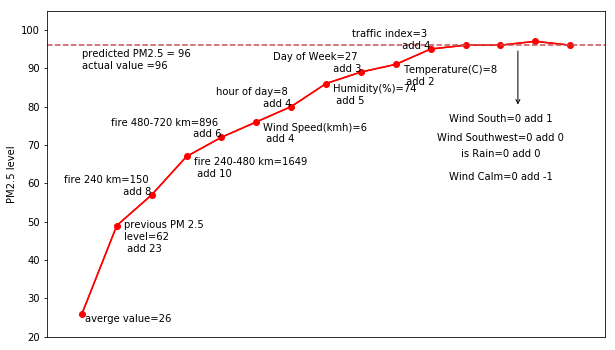

In [869]:
##visualize model prediction 
fig,ax = plt.subplots(figsize=(10,6))
inter_df['predict_value'].plot(color='red')
inter_df['predict_value'].plot(marker='o',color='red')
plt.xticks([])
plt.ylabel('PM2.5 level')

plt.xlim(-1,15)
plt.ylim(20,105)
plt.axhline(y=96, color='r', linestyle='--')
plt.text(x=0, y=95, s='predicted PM2.5 = 96\nactual value =96',verticalalignment='top')

for i,idx in enumerate(inter_df.index):
    y_loc = inter_df.loc[idx,'predict_value']-2
    value = inter_df.loc[idx,'value'].round(0)
    contri = inter_df.loc[idx,'contribution'].round(2)
    if i ==0:
        plt.text(x=i+0.1,y=y_loc,s= idx+f'={value}')
    elif i in [1,3,5,7,9]:
        plt.text(x=i+0.2,y=y_loc-1,s= idx+f'={value} \n add {contri}',verticalalignment='center')  
    elif i in [2,4,6]:
         plt.text(x=i,y=y_loc+2,s= idx+f'={value} \n add {contri}',horizontalalignment='right')
    elif i in [8,10]:
        plt.text(x=i,y=y_loc+2,s= idx+f'={value} \n add {contri}',horizontalalignment='right')

for i in range(11,15):
    y_loc = inter_df.iloc[i].predict_value - 15 - (i - 10)*5
    value = inter_df.iloc[i].value.round(0)
    contri = inter_df.iloc[i].contribution.round(2)
    plt.text(x=12,y=y_loc,s= inter_df.index[i]+f'={value} add {contri}',horizontalalignment='center')
 
plt.annotate("", xy=(12.5, 80), xytext=(12.5, 95), arrowprops=dict(arrowstyle="->"))



In [851]:
idx = 23771
row = X_trn.iloc[idx].values
prediction, bias, contributions = ti.predict(m, row.reshape(1, -1))
bias_df = pd.DataFrame({'feature':'bias','value':bias[0],'contribution':bias[0]},index =[0])
bias_df = bias_df.set_index('feature')

In [852]:

inter_df = pd.concat([pd.DataFrame(X_trn.iloc[idx]).reset_index(),pd.Series(contributions[0])],
           ignore_index=True,axis=1)
inter_df.columns = ['feature','value','contribution']
inter_df = inter_df.set_index('feature')
#order by feature of importance
inter_df = inter_df.reindex(fi_per.cols)
inter_df = pd.concat([bias_df,inter_df],axis=0,sort=False)

inter_df['predict_value'] = inter_df['contribution'].rolling(15,min_periods=0).sum()
inter_df.index = ['averge value','previous PM 2.5\nlevel', 'fire 240 km', 'fire 240-480 km', 'fire 480-720 km',
                  'Wind Speed(kmh)','hour of day','Humidity(%)','Day of Week','Temperature(C)','traffic index',
                  'Wind South','Wind Southwest','is Rain', 'Wind Calm']
inter_df = inter_df.round().astype(int)

In [853]:
inter_df

value  contribution  predict_value
averge value               26            26             26
previous PM 2.5\nlevel     16           -11             15
fire 240 km               276             1             16
fire 240-480 km          1008             1             17
fire 480-720 km          1755             1             18
Wind Speed(kmh)             1             0             17
hour of day                19            -1             16
Humidity(%)                62            -1             15
Day of Week                30            -1             14
Temperature(C)             13            -1             13
traffic index               4            -2             11
Wind South                  1            -1             10
Wind Southwest              0             0             10
is Rain                     0             0             10
Wind Calm                   0             0             10

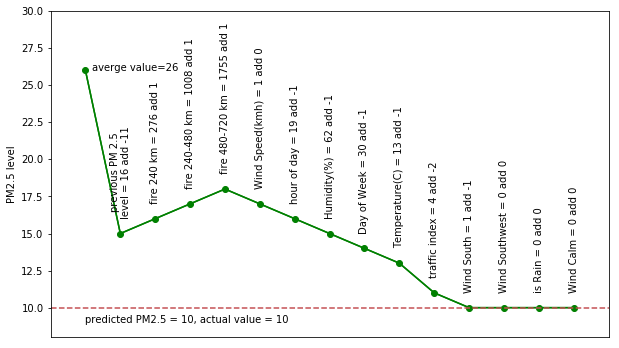

In [858]:
##visualize model prediction 
fig,ax = plt.subplots(figsize=(10,6))
inter_df['predict_value'].plot(color='green')
inter_df['predict_value'].plot(marker='o',color='green')
plt.xticks([])
plt.ylabel('PM2.5 level')

plt.xlim(-1,15)
plt.ylim(8,30)
plt.axhline(y=10, color='r', linestyle='--')
plt.text(x=0, y=9, s='predicted PM2.5 = 10, actual value = 10')

# annotate each dot 
i=0
y_loc = inter_df.iloc[i].predict_value 
value = inter_df.iloc[i].value.round(0)
contri = inter_df.iloc[i].contribution.round(2)
plt.text(x=i+0.2,y=y_loc,s= inter_df.index[i]+f'={value}',horizontalalignment='left')


for i in range(1,15):
    y_loc = inter_df.iloc[i].predict_value 
    value = inter_df.iloc[i].value.round(0)
    contri = inter_df.iloc[i].contribution.round(2)
    plt.text(x=i,y=y_loc+1,s= inter_df.index[i]+f' = {value} add {contri}',horizontalalignment='center',verticalalignment='bottom', rotation=90)



# Future Work

In summary, fitting the ML model to descripe factors most contribute to the air pollution level in Bangkok. The ML feature of importances point to the high level of agricultural burning in winter season. The model still achieve about 66% - 73% R-squared. The fact that the PM2.5 data is an autorregressive model, which has a high dependent on the previous value may explain why the model is not as accurate. In the future, employing generative model such as ARIMA and LSTM with other environmental factors included could improve this model. 